# **Cross-Lingual Sentiment Dynamics and Bias Detection in Product Reviews** 

#### Project By: Shreya Kulkarni

## Project Description

The rapid expansion of global e-commerce has transformed how consumers express opinions and make purchasing decisions. With billions of product reviews generated annually across diverse languages, online platforms now rely heavily on user-generated content as both a source of trust for customers and a key dataset for business intelligence. Sentiment analysis-identifying and classifying opinions expressed in text- has therefore emerged as a critical research area in natural language processing (NLP). Early approaches relied on lexicon-based and traditional machine learning methods, which achieved moderate success for English corpora but performed poorly in multilingual contexts. More recently, transformer-based models such as BERT and XLM-R have advanced cross-lingual representation learning, yet challenges remain in accurately capturing sentiment across diverse languages and cultural contexts. Simultaneously, the authenticity of reviews has come under scrutiny, with growing evidence of manipulation through fake, biased, or promotional content. These developments highlight the urgent need for frameworks that can both classify sentiment and detect bias in multilingual review data. The primary goal of this research initiative is to create a sophisticated multilingual natural language processing (NLP) system that can effectively classify sentiment and identify biased or fake reviews. 

## Project Setup

### Importing the libraries

In [1]:
# install missing libraries
!pip install hdbscan

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: C:\Users\shrey\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [2]:
import pandas as pd
import numpy as np
import os
import re  #fixes NameError for regular expressions
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from textblob import TextBlob
from sklearn.feature_extraction.text import TfidfVectorizer
from sentence_transformers import SentenceTransformer
import hdbscan
from transformers import AutoTokenizer, AutoModel, AutoModelForSequenceClassification
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
from xgboost import XGBClassifier
import torch
from scipy.special import softmax
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from textblob import TextBlob
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
from transformers import AutoTokenizer, AutoModel, AutoModelForSequenceClassification
import torch
from sklearn.ensemble import IsolationForest
from sklearn.metrics import roc_auc_score, average_precision_score, roc_curve, precision_recall_curve

In [3]:
# (stopword removal + tokenization + lemmatization) packages 
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')   
nltk.download('vader_lexicon')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\shrey\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\shrey\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\shrey\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\shrey\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\shrey\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

### Importing the datasets

In [4]:
# uploading from the system
folder = r'C:\Users\shrey\Downloads\lang'

In [5]:
# importing the sub datasets
train = pd.read_csv(os.path.join(folder, 'train.csv')).sample(n=10000, random_state=42)
test = pd.read_csv(os.path.join(folder, 'test.csv')).sample(n=3000, random_state=42)
valid = pd.read_csv(os.path.join(folder, 'validation.csv')).sample(n=3000, random_state=42)

In [6]:
# checking column list
train.columns

Index(['Unnamed: 0', 'review_id', 'product_id', 'reviewer_id', 'stars',
       'review_body', 'review_title', 'language', 'product_category'],
      dtype='object')

In [7]:
# checking the shape
train.shape

(10000, 9)

In [8]:
# dataframe first look
train.head(5)

,Unnamed: 0,review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category
372605,372605,en_0492102,product_en_0873014,reviewer_en_0235602,5,Love it! Not because it works well on my baby ...,Best lotion I’ve ever used,en,drugstore
551204,551204,es_0148171,product_es_0814100,reviewer_es_0772288,4,Un poco pequeña para el coche donde la instalé...,"Correcta, pero un poco pequeña",es,pet_products
240320,240320,en_0936016,product_en_0954356,reviewer_en_0764561,2,I used about 30-40 pumps of this and it made s...,Doesn't Bubble!,en,drugstore
1047361,1047361,zh_0376841,product_zh_0183723,reviewer_zh_0215022,2,一拿到表的时候，还算好看，但是表盘背后有十分多的划痕，就是那种被磨损的痕迹，一看就不是新货，...,信誉有待斟酌,zh,watch
555362,555362,es_0957933,product_es_0964116,reviewer_es_0117597,4,Regalo. Esta bien pero hubiera sido mejor si s...,Cumple con lo que publicita,es,home


The dataset contains a combination of six languages- english, french, german, chinese, japanese and spanish.
The columns have reviewer id, product id, reviews, languages and product category.

## Data Cleaning & Preprocessing

In [9]:
# function to clean review text body
def preprocess_text(text):
    if pd.isnull(text):
        return ""

    # converting to lowercase
    text = text.lower()

    #removing URLs, HTML tags
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'<.*?>', '', text)

    #removing punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))

    #removing numbers
    text = re.sub(r'\d+', '', text)

    #tokenization
    tokens = nltk.word_tokenize(text)

    #removing stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]

    #lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    #joining tokens back to string
    cleaned_text = ' '.join(tokens)

    return cleaned_text

In [10]:
# applying cleaning on all datasets
train['cleaned_review'] = train['review_body'].apply(preprocess_text)
test['cleaned_review'] = test['review_body'].apply(preprocess_text)
valid['cleaned_review'] = valid['review_body'].apply(preprocess_text)

In [11]:
# sample look of data cleaning
print("Original train:\n", train['review_body'].iloc[2])
print("\nCleaned train:\n", train['cleaned_review'].iloc[2])

print("Original test:\n", test['review_body'].iloc[2])
print("\nCleaned test:\n", test['cleaned_review'].iloc[2])

print("Original validation:\n", valid['review_body'].iloc[2])
print("\nCleaned validation:\n", valid['cleaned_review'].iloc[2])

Original train:
 I used about 30-40 pumps of this and it made some small bubbles (not "proper" bubbles but more like the tiny ones you get when you use soap or shampoo in the bath) after a couple of minutes all of the bubbles had completely disappeared. I've given two stars as the scent was nice. Perhaps it's better for babies who have extremely short baths?

Cleaned train:
 used pump made small bubble proper bubble like tiny one get use soap shampoo bath couple minute bubble completely disappeared ive given two star scent nice perhaps better baby extremely short bath
Original test:
 プラスチックの商品壊れやすいのでこちらの商品を購入しました。 錆にも強く、長持ちできそうです。

Cleaned test:
 プラスチックの商品壊れやすいのでこちらの商品を購入しました。 錆にも強く、長持ちできそうです。
Original validation:
 疲労軽減の為渓流釣りに使用。良さそうです。継続使用します。納期掛かるのですぐ欲しい方は他を当たった方が良いです。

Cleaned validation:
 疲労軽減の為渓流釣りに使用。良さそうです。継続使用します。納期掛かるのですぐ欲しい方は他を当たった方が良いです。


The above data cleaning transforms the raw data into a usable format for further investigations and predictions.

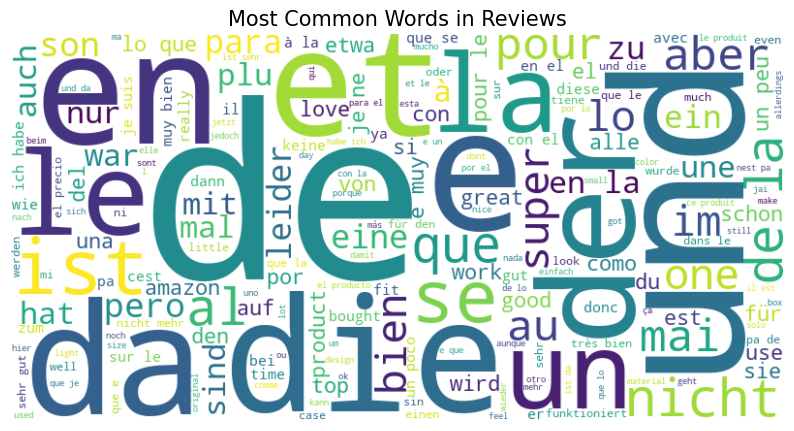

In [12]:
# word cloud for the most used words in the review
text = " ".join(train['cleaned_review'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most Common Words in Reviews', fontsize=15)
plt.show()

The above word cloud shows the most used words in reviews. It has a combination of words from the six languages.

In [20]:
import langid   
from deep_translator import GoogleTranslator   
from tqdm.notebook import tqdm   

In [21]:
# translate the languages to english
langid.set_languages(['en', 'es', 'fr', 'de', 'zh', 'ja'])

# Detect language for each review
#train["lang"] = train["cleaned_review"].apply(lambda x: langid.classify(str(x))[0] if isinstance(x, str) else "en")

# Split into English and non-English
english_reviews = train[train["language"] == "en"].copy()
non_english_reviews = train[train["language"] != "en"].copy()

translator = GoogleTranslator(source='auto', target='en')

# Batch translate non-English reviews
batch_size = 200  # adjust based on speed and API limits
translated_texts = []

print(f"Translating {len(non_english_reviews)} non-English reviews...\n")

for i in tqdm(range(0, len(non_english_reviews), batch_size), desc="Translating Batches"):
    batch = non_english_reviews["cleaned_review"].iloc[i:i+batch_size].tolist()
    try:
        translated_batch = translator.translate_batch(batch)
    except Exception as e:
        print(f" Batch {i} translation error: {e}")
        translated_batch = batch  # fallback: keep original text
    translated_texts.extend(translated_batch)

# Assign translations back
non_english_reviews["translated"] = translated_texts
english_reviews["translated"] = english_reviews["cleaned_review"]

# Combine back
train_translated = pd.concat([english_reviews, non_english_reviews]).sort_index()

print(train_translated[["cleaned_review", "language", "translated"]])

Translating 8382 non-English reviews...



Translating Batches:   0%|          | 0/42 [00:00<?, ?it/s]

                                            cleaned_review language  \
31               bi heute ist artikel noch nicht geliefert       de   
225      einfach nicht schön e sieht nicht au wie eine ...       de   
314      yeahhh plastikfreie zahnseide verpackt plastik...       de   
535      finger weg davon hat nichts mit den bildern zu...       de   
834      nach einem halben jahr bricht da gehäuse von d...       de   
...                                                    ...      ...   
1199565   读起来酣畅淋漓，特别是到第三部的时候，各种奇思妙想纷至沓来，给人的感觉棒极了。感谢大刘，给五星！       zh   
1199620                   👍快捷，号下单号就收到了，以前没有上过亚马逊，现在买东西太方便了       zh   
1199674                       鞋码很合适，发货速度也好，正品。和之前穿过的一样的舒服。       zh   
1199848                   玩大型游戏很快，屏幕也很清晰，真的很不错，买对 了，外观也很时尚       zh   
1199884                             书的品相好，内容丰富，是一本好书，值得拥有。       zh   

                                                translated  
31                   bi Today is not yet delivered article  
225      Just not beautif

The review column is translated into english to understand the words used. The below word cloud demonstartes that. The words like, 'good', 'well', 'great' showcases that the words used by people in reviews is specific and generic everyday use. 

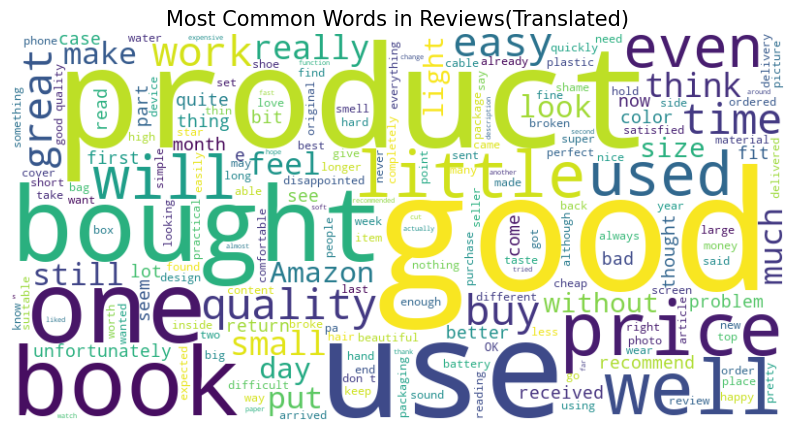

In [22]:
# word cloud for most used words in review in english
text = " ".join(train_translated['translated'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most Common Words in Reviews(Translated)', fontsize=15)
plt.show()

In [23]:
# Merge the translated column back into the original train dataset
train["translated"] = train_translated["translated"]

# Optional: check the final dataset
print(train[[
    'Unnamed: 0', 'review_id', 'product_id', 'reviewer_id', 'stars',
    'review_body', 'review_title', 'language', 'product_category',
    'cleaned_review', 'translated'
]].head())

         Unnamed: 0   review_id          product_id          reviewer_id  \
372605       372605  en_0492102  product_en_0873014  reviewer_en_0235602   
551204       551204  es_0148171  product_es_0814100  reviewer_es_0772288   
240320       240320  en_0936016  product_en_0954356  reviewer_en_0764561   
1047361     1047361  zh_0376841  product_zh_0183723  reviewer_zh_0215022   
555362       555362  es_0957933  product_es_0964116  reviewer_es_0117597   

         stars                                        review_body  \
372605       5  Love it! Not because it works well on my baby ...   
551204       4  Un poco pequeña para el coche donde la instalé...   
240320       2  I used about 30-40 pumps of this and it made s...   
1047361      2  一拿到表的时候，还算好看，但是表盘背后有十分多的划痕，就是那种被磨损的痕迹，一看就不是新货，...   
555362       4  Regalo. Esta bien pero hubiera sido mejor si s...   

                           review_title language product_category  \
372605       Best lotion I’ve ever used       en        dru

## Bias Detection

In [25]:
# create a bias lexicon

bias_words = {
    "positive_bias": [
        "amazing", "incredible", "unbelievable", "flawless", "outstanding", 
        "world-class", "perfect", "mind-blowing", "life-changing", 
        "revolutionary", "best-ever", "spectacular", "genius", "brilliant", 
        "phenomenal", "masterpiece", "must-have", "game-changer", "superb", "luxurious"
    ],
    "negative_bias": [
        "horrible", "awful", "pathetic", "useless", "garbage", "worst-ever", 
        "disaster", "rip off", "scam", "fake", "dreadful", "trash", "worthless", 
        "terrible", "nightmare", "joke", "fraud", "cheap", "nasty", "unacceptable"
    ],
    "discriminatory_bias": [
        "racist", "sexist", "homophobic", "xenophobic", "intolerant", 
        "discriminatory", "prejudiced", "anti", "bigoted", "biased", "chauvinistic"
    ],
    "urgency_bias": [
        "limited-time", "act now", "hurry", "last chance", "exclusive", 
        "only-today", "rare", "once-in-a-lifetime", "don’t miss", "guaranteed", 
        "promise", "risk-free", "unbeatable"
    ],
    "loaded_opinion": [
        "clearly", "obviously", "without a doubt", "no brainer", 
        "in my opinion", "frankly", "trust me", "believe me", "undeniably", 
        "hands down", "surely"
    ]
}

# flatten all bias words into one set for scoring
all_bias_words = set(word.lower() for category in bias_words.values() for word in category)

# function to calculate bias score
def calculate_bias_score(text):
    if pd.isna(text):
        return 0
    text = text.lower()
    words = re.findall(r'\b\w+\b', text)  # extract words
    return sum(1 for w in words if w in all_bias_words)

In [26]:
# apply the function to datasets
train["bias_score"] = train["cleaned_review"].apply(calculate_bias_score)
test["bias_score"] = test["cleaned_review"].apply(calculate_bias_score)
valid["bias_score"] = valid["cleaned_review"].apply(calculate_bias_score)

In [27]:
# check results
print(train[["cleaned_review", "bias_score"]].head(2))

                                           cleaned_review  bias_score
372605  love work well baby work well memy skin feel s...           0
551204  un poco pequeña para el coche donde la instalé...           0


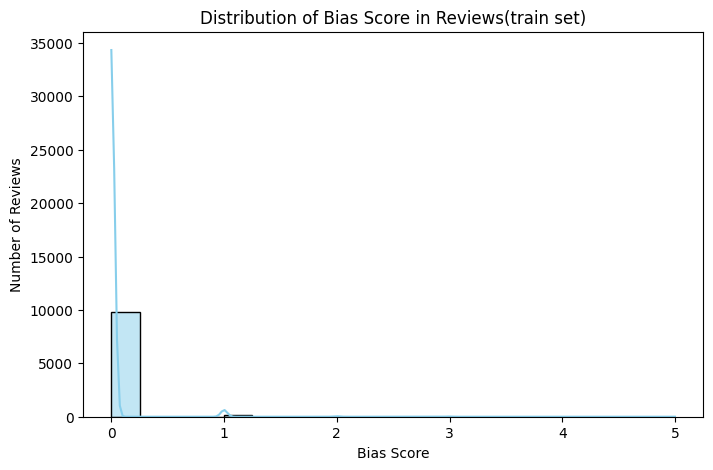

In [28]:
# plot for distribution of bias scores
plt.figure(figsize=(8,5))
sns.histplot(train['bias_score'], bins=20, kde=True, color='skyblue')
plt.title("Distribution of Bias Score in Reviews(train set)")
plt.xlabel("Bias Score")
plt.ylabel("Number of Reviews")
plt.show()

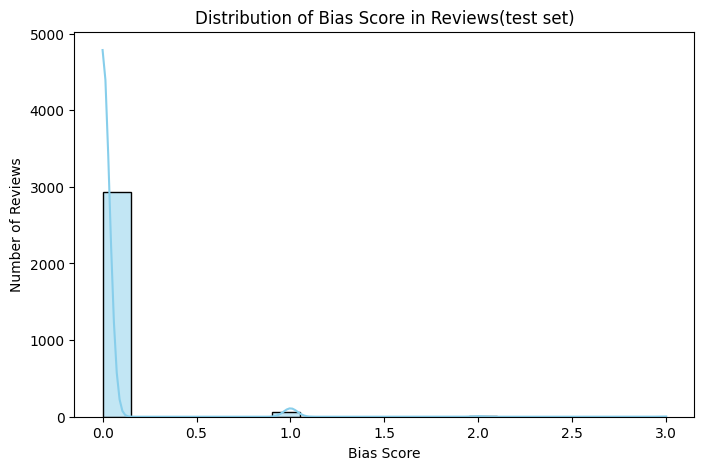

In [29]:
# plot for distribution of bias scores
plt.figure(figsize=(8,5))
sns.histplot(test['bias_score'], bins=20, kde=True, color='skyblue')
plt.title("Distribution of Bias Score in Reviews(test set)")
plt.xlabel("Bias Score")
plt.ylabel("Number of Reviews")
plt.show()

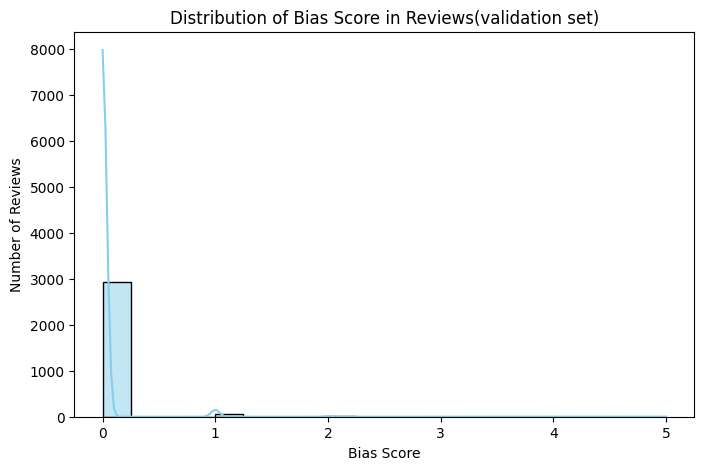

In [30]:
# plot for distribution of bias scores
plt.figure(figsize=(8,5))
sns.histplot(valid['bias_score'], bins=20, kde=True, color='skyblue')
plt.title("Distribution of Bias Score in Reviews(validation set)")
plt.xlabel("Bias Score")
plt.ylabel("Number of Reviews")
plt.show()

To summarise the bias scoring, the bias score distribution demonstrates a heavily skewed pattern, with the vast majority of reviews (approximately 9,000 out of 10,000) receiving a bias score of 0, indicating genuine reviews. This distribution suggests that while fake reviews exist, they represent a relatively small proportion of the overall review ecosystem. The secondary peak around bias score 1 indicates a cluster of potentially problematic reviews that warrant further investigation.

From a business perspective, this distribution pattern is encouraging for platform integrity but highlights the critical importance of detecting the minority of fraudulent content that can disproportionately impact consumer trust and purchasing decisions.

### Bias Feature Engineering

In [31]:
# features to calculate bias
for df in [train, test, valid]:
    
    # Review length (in words)
    df['review_length'] = df['cleaned_review'].apply(lambda x: len(str(x).split()))
    
    # Sentiment polarity
    df['sentiment_polarity'] = df['cleaned_review'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)
    
    # All-caps words
    df['all_caps_count'] = df['cleaned_review'].apply(lambda x: sum(1 for word in str(x).split() if word.isupper()))
    
    # Exclamation marks
    df['exclam_count'] = df['cleaned_review'].apply(lambda x: str(x).count('!'))
    
    # Extreme rating
    df['extreme_rating'] = df['stars'].apply(lambda x: 1 if x in [1, 5] else 0)
    
    # Fake review labeling
    df['fake_review_label'] = df.apply(lambda row: 1 if (row['stars'] >= 4 and row['review_length'] < 5) else 0, axis=1)

In [32]:
# check a sample
print(train[['cleaned_review', 'review_length', 'sentiment_polarity', 'all_caps_count', 
             'exclam_count', 'extreme_rating', 'fake_review_label', 'bias_score']].head())

                                            cleaned_review  review_length  \
372605   love work well baby work well memy skin feel s...             17   
551204   un poco pequeña para el coche donde la instalé...             20   
240320   used pump made small bubble proper bubble like...             32   
1047361  一拿到表的时候，还算好看，但是表盘背后有十分多的划痕，就是那种被磨损的痕迹，一看就不是新货，...              1   
555362   regalo esta bien pero hubiera sido mejor si se...             15   

         sentiment_polarity  all_caps_count  exclam_count  extreme_rating  \
372605             0.466667               0             0               1   
551204             0.000000               0             0               0   
240320             0.135714               0             0               0   
1047361            0.000000               0             0               0   
555362             0.000000               0             0               0   

         fake_review_label  bias_score  
372605                   0       

## Bias Detection Analysis

#### Review Distribution

C:\Users\shrey\AppData\Local\Temp\ipykernel_38412\1910864168.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=review_counts.index, y=review_counts.values, palette='viridis')


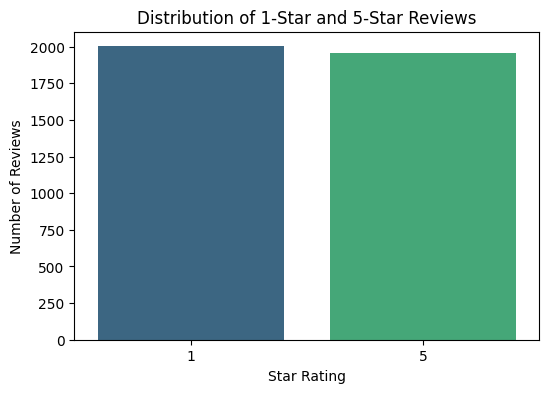

In [33]:
# review distribution
filtered = train[train['stars'].isin([1, 5])]  # only 1-star and 5-star reviews

# counting reviews 
review_counts = filtered['stars'].value_counts().sort_index()

# plot the distribution
plt.figure(figsize=(6,4))
sns.barplot(x=review_counts.index, y=review_counts.values, palette='viridis')
plt.title("Distribution of 1-Star and 5-Star Reviews")
plt.xlabel("Star Rating")
plt.ylabel("Number of Reviews")
plt.show()

The analysis of 1-star and 5-star review distributions reveals nearly equal representation (approximately 2,000 reviews each), indicating a polarized rating pattern common in online review systems. This bimodal distribution reflects the psychological tendency for consumers to leave reviews primarily when they have strongly positive or negative experiences.

#### Product Diversity 

In [34]:
# product diversity by the user
user_diversity = train.groupby('reviewer_id')['product_category'].nunique().reset_index()
user_diversity.rename(columns={'product_category': 'num_categories'}, inplace=True)

# inspect the top users with most diverse reviews
print(user_diversity.sort_values(by='num_categories', ascending=False).head(10))

              reviewer_id  num_categories
342   reviewer_de_0204309               2
1067  reviewer_de_0631135               2
1607  reviewer_de_0950535               2
7414  reviewer_ja_0474247               2
7451  reviewer_ja_0498650               2
7593  reviewer_ja_0582293               2
8501  reviewer_zh_0138113               2
9385  reviewer_zh_0626499               2
9824  reviewer_zh_0906972               2
9974  reviewer_zh_0990852               1


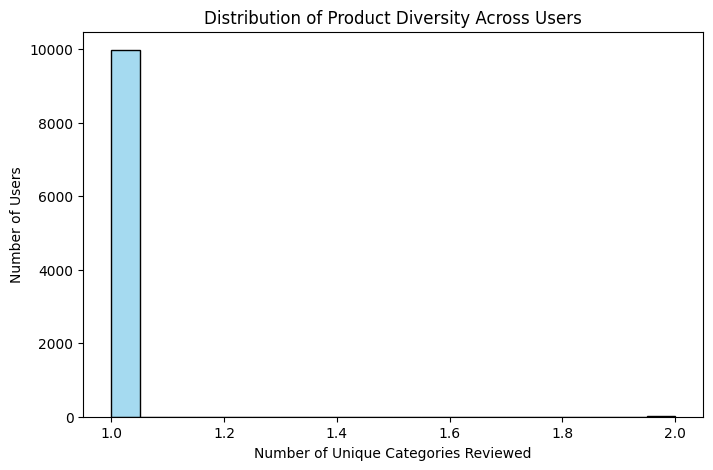

In [35]:
# plot distribution of product diversity
plt.figure(figsize=(8,5))
sns.histplot(user_diversity['num_categories'], bins=20, kde=False, color='skyblue')
plt.title("Distribution of Product Diversity Across Users")
plt.xlabel("Number of Unique Categories Reviewed")
plt.ylabel("Number of Users")
plt.show()

The product diversity analysis shows an overwhelming concentration of users reviewing products from only one category (approximately 10,000 users), suggesting specialized purchasing behaviour or potential limitations in the dataset scope.

#### Template Detection

In [36]:
# only using the review text column
reviews = train['cleaned_review'].astype(str)  

# convert reviews to TF-IDF vectors
vectorizer = TfidfVectorizer(ngram_range=(2,5), stop_words='english')  # bigrams to 5-grams
tfidf_matrix = vectorizer.fit_transform(reviews)

# compute pairwise cosine similarity
similarity_matrix = cosine_similarity(tfidf_matrix)

# find highly similar reviews
threshold = 0.8
pairs = np.argwhere(similarity_matrix > threshold)

# remove self-pairs
pairs = [ (i,j) for i,j in pairs if i < j ]

print(f"Number of highly similar review pairs: {len(pairs)}")
print("Sample similar pairs (indices):", pairs[:10])

# inspect the reviews
for i,j in pairs[:5]:
    print("\n---Review 1---\n", reviews.iloc[int(i)])
    print("\n---Review 2---\n", reviews.iloc[int(j)])

Number of highly similar review pairs: 27
Sample similar pairs (indices): [(np.int64(18), np.int64(532)), (np.int64(18), np.int64(2274)), (np.int64(18), np.int64(4035)), (np.int64(18), np.int64(7024)), (np.int64(18), np.int64(9264)), (np.int64(18), np.int64(9379)), (np.int64(532), np.int64(2274)), (np.int64(532), np.int64(4035)), (np.int64(532), np.int64(7024)), (np.int64(532), np.int64(9264))]

---Review 1---
 以前从不去评价，不知道浪费了多少积分，现在知道积分可以换钱，就要好好评价了，后来我就把这段话复制走了，既能赚积分，还省事，走到哪复制到哪，最重要的是，不用认真的评论了，不用想还差多少字，直接发出就可以了，推荐给大家！

---Review 2---
 好，以前从不去评价，不知道浪费了多少积分，现在知道积分可以换钱，就要好好评价了，后来我就把这段话复制走了，既能赚积分，还省事，走到哪复制到哪，最重要的是，不用认真的评论了，不用想还差多少字，直接发出就可以了，推荐给大家！

---Review 1---
 以前从不去评价，不知道浪费了多少积分，现在知道积分可以换钱，就要好好评价了，后来我就把这段话复制走了，既能赚积分，还省事，走到哪复制到哪，最重要的是，不用认真的评论了，不用想还差多少字，直接发出就可以了，推荐给大家！

---Review 2---
 好，以前从不去评价，不知道浪费了多少积分，现在知道积分可以换钱，就要好好评价了，后来我就把这段话复制走了，既能赚积分，还省事，走到哪复制到哪，最重要的是，不用认真的评论了，不用想还差多少字，直接发出就可以了，推荐给大家！！

---Review 1---
 以前从不去评价，不知道浪费了多少积分，现在知道积分可以换钱，就要好好评价了，后来我就把这段话复制走了，既能赚积分，还省事，走到哪复制到哪，最重要的是，不

The above similar pairings reveal limitations of similarity matrix in terms of languages. 

#### Clustering of Similar Reviews

Using Sentence Transformer and HDBSCAN to cluster similar reviews.

In [37]:
model = SentenceTransformer('all-MiniLM-L6-v2')

In [38]:
# 0) HARD-RESET INDICES (prevents KeyError from label alignment)
for name, df in (("train", train), ("valid", valid), ("test", test)):
    df.reset_index(drop=True, inplace=True)
    assert (df.index == pd.RangeIndex(len(df))).all(), f"{name} index is not 0..N-1"

# 1) HELPER: cluster a split strictly by position
def cluster_split(df, text_col="cleaned_review", min_cluster_size=5):
    texts = df[text_col].astype(str).tolist()
    # Encode to embeddings (SentenceTransformer/your model)
    emb = model.encode(texts, show_progress_bar=True)
    # HDBSCAN clustering
    labels = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size, metric="euclidean").fit_predict(emb)

    # --- SAFETY CHECKS ---
    print(f"[{text_col}] len(df)={len(df)}, len(labels)={len(labels)}")
    # Assign strictly by position (no alignment by label)
    df.loc[:, "semantic_cluster"] = labels  # same length → no alignment issues
    return emb, labels

# 2) RUN PER SPLIT
train_emb,  train_labels  = cluster_split(train,  "cleaned_review", min_cluster_size=5)
valid_emb,  valid_labels  = cluster_split(valid,  "cleaned_review", min_cluster_size=5)
test_emb,   test_labels   = cluster_split(test,   "cleaned_review", min_cluster_size=5)

# 3) INSPECT CLUSTER SIZES (don't overwrite the variable each time)
train_cluster_counts = train["semantic_cluster"].value_counts()
valid_cluster_counts = valid["semantic_cluster"].value_counts()
test_cluster_counts  = test["semantic_cluster"].value_counts()

print("Train clusters:\n", train_cluster_counts.head(10))
print("\nValid clusters:\n", valid_cluster_counts.head(10))
print("\nTest clusters:\n",  test_cluster_counts.head(10))

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

[cleaned_review] len(df)=10000, len(labels)=10000


Batches:   0%|          | 0/94 [00:00<?, ?it/s]

[cleaned_review] len(df)=3000, len(labels)=3000


Batches:   0%|          | 0/94 [00:00<?, ?it/s]

[cleaned_review] len(df)=3000, len(labels)=3000
Train clusters:
 semantic_cluster
-1     4642
 10    3298
 14    1677
 6      176
 15      89
 8       25
 2       17
 0       16
 4       12
 5        8
Name: count, dtype: int64

Valid clusters:
 semantic_cluster
 2    1254
 3     987
-1     692
 1      61
 0       6
Name: count, dtype: int64

Test clusters:
 semantic_cluster
 2    1378
 1     988
-1     555
 3      62
 0      17
Name: count, dtype: int64


C:\Users\shrey\AppData\Local\Temp\ipykernel_38412\1775627833.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_clusters.index, y=top_clusters.values, palette='viridis')


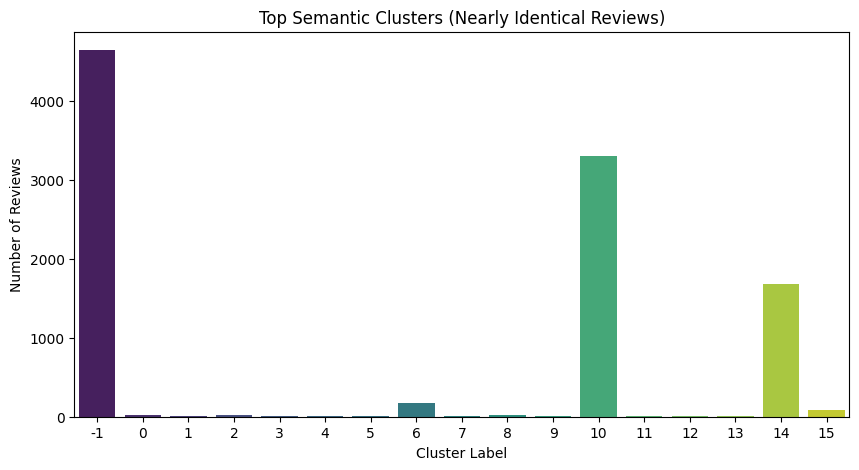

In [39]:
# visualize top clusters
top_clusters = train_cluster_counts[train_cluster_counts > 1]
plt.figure(figsize=(10,5))
sns.barplot(x=top_clusters.index, y=top_clusters.values, palette='viridis')
plt.title("Top Semantic Clusters (Nearly Identical Reviews)")
plt.xlabel("Cluster Label")
plt.ylabel("Number of Reviews")
plt.show()

The semantic clustering analysis identifies several distinct groups of nearly identical reviews, with the largest clusters containing over 4,000 and 3,000 reviews respectively. This clustering pattern strongly suggests coordinated inauthentic behavior, such as review farms or bot networks generating similar content across multiple products or accounts.

#### Promotional and Emotional Bias

In [40]:
def detect_promotional_bias(text):
    return any(phrase in text for phrase in bias_words)

# apply to cleaned text
train['promotional_bias'] = train['cleaned_review'].apply(detect_promotional_bias)
test['promotional_bias'] = test['cleaned_review'].apply(detect_promotional_bias)
valid['promotional_bias'] = valid['cleaned_review'].apply(detect_promotional_bias)

# emotional sentiment extremes
train['emotional_bias'] = train['sentiment_polarity'].apply(lambda x: 1 if abs(x) > 0.8 else 0)
test['emotional_bias'] = test['sentiment_polarity'].apply(lambda x: 1 if abs(x) > 0.8 else 0)
valid['emotional_bias'] = valid['sentiment_polarity'].apply(lambda x: 1 if abs(x) > 0.8 else 0)

# final bias flag
train['biased_review_flag'] = train[['promotional_bias', 'emotional_bias']].sum(axis=1).apply(lambda x: 1 if x > 0 else 0)
test['biased_review_flag'] = test[['promotional_bias', 'emotional_bias']].sum(axis=1).apply(lambda x: 1 if x > 0 else 0)
valid['biased_review_flag'] = valid[['promotional_bias', 'emotional_bias']].sum(axis=1).apply(lambda x: 1 if x > 0 else 0)

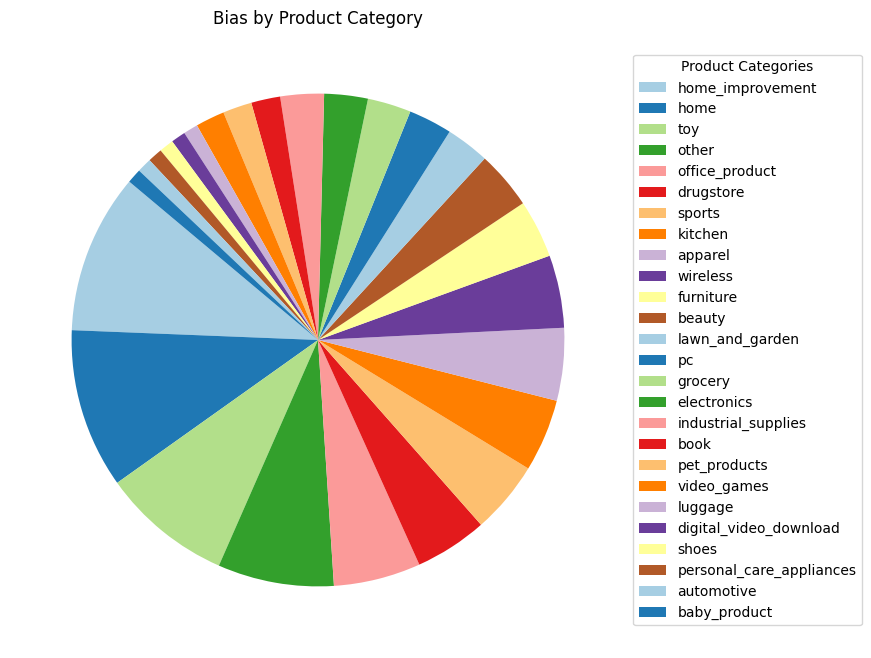

In [41]:
bias_by_category = (
    pd.concat([
        train[train['biased_review_flag'] == 1]['product_category'],
        test[test['biased_review_flag'] == 1]['product_category'],
        valid[valid['biased_review_flag'] == 1]['product_category']
    ])
    .value_counts()
)

plt.figure(figsize=(8, 8))
wedges, texts = plt.pie(
    bias_by_category,
    labels=None,
    startangle=140,
    colors=plt.cm.Paired.colors
)

plt.legend(
    wedges,
    bias_by_category.index,
    title="Product Categories",
    loc="center left",
    bbox_to_anchor=(1, 0, 0.5, 1)
)

plt.title("Bias by Product Category", fontsize=12)
plt.show()

The product category analysis reveals uneven distribution of biased reviews across different categories. Categories such as lawn and garden, electronics, and baby products show varying levels of bias representation. This heterogeneity suggests that certain product categories may be more susceptible to review manipulation, possibly due to factors such as purchase frequency, price points, or competitive intensity. They also show that categories that are biased may be due to the preference of choices and persoanl tastes.

#### Categorising Reviews

In [42]:
def categorize_length(x):
    if x < 50:
        return "Short"
    elif x < 150:
        return "Medium"
    else:
        return "Long"

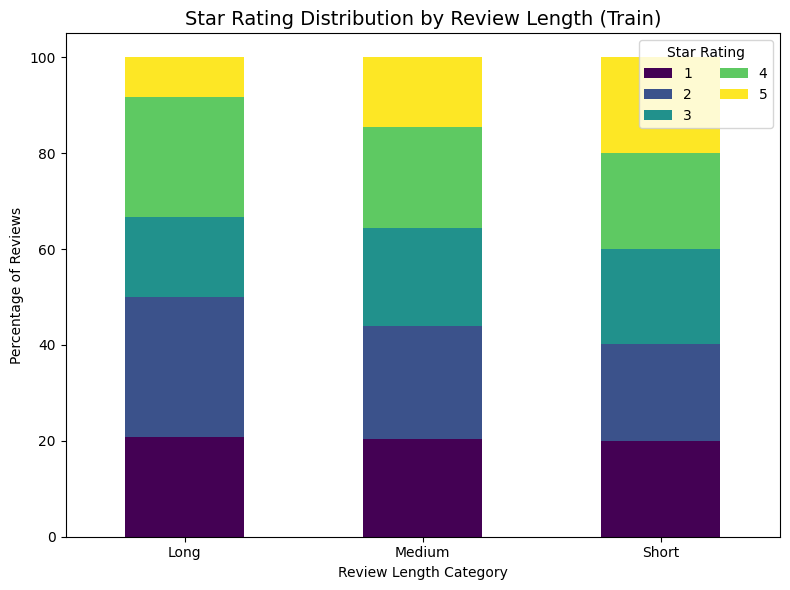

In [43]:
# Function to categorize and plot for a given dataset
def plot_review_length_vs_stars(df, dataset_name="Train"):
    # Create length category column
    df['review_length_cat'] = df['review_length'].apply(categorize_length)
    
    # Group by review length category and star ratings
    length_star_counts = df.groupby(['review_length_cat', 'stars']).size().unstack(fill_value=0)
    
    # Normalize (percentage)
    length_star_percent = length_star_counts.div(length_star_counts.sum(axis=1), axis=0) * 100
    
    # Plot stacked bar chart
    length_star_percent.plot(
        kind='bar',
        stacked=True,
        figsize=(8, 6),
        colormap="viridis"
    )
    
    plt.title(f"Star Rating Distribution by Review Length ({dataset_name})", fontsize=14)
    plt.xlabel("Review Length Category")
    plt.ylabel("Percentage of Reviews")
    plt.xticks(rotation=0)
    plt.legend(title="Star Rating", loc='upper right', ncol=2)
    plt.tight_layout()
    plt.show()

# Run for any one dataset 
plot_review_length_vs_stars(train, "Train")
# plot_review_length_vs_stars(test, "Test")
# plot_review_length_vs_stars(valid, "Valid")

Review length categories (short, medium, long) show similar star rating distributions, with each category containing roughly 20% 1-star, 30% 2-star, 20% 3-star, 25% 4-star, and 15% 5-star reviews.

#### Language Bias

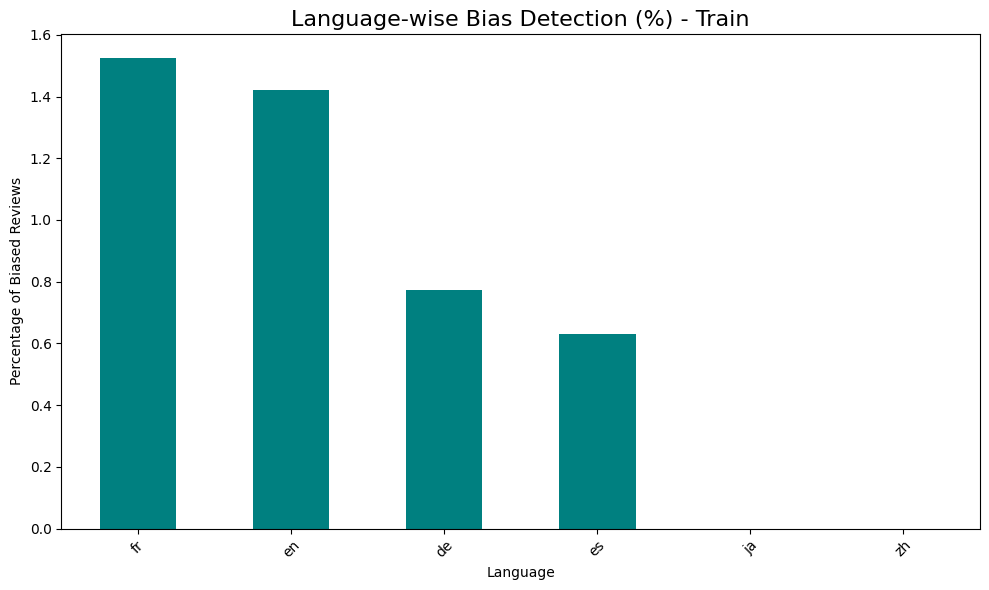

In [44]:
def plot_bias_by_language(df, dataset_name="Train"):
    
    # Calculate percentage of biased reviews per language
    bias_lang = df.groupby('language')['biased_review_flag'].mean() * 100  
    
    # Sort for cleaner plot
    bias_lang = bias_lang.sort_values(ascending=False)
    
    # Plot bar chart
    plt.figure(figsize=(10, 6))
    bias_lang.plot(kind='bar', color='teal')
    plt.title(f"Language-wise Bias Detection (%) - {dataset_name}", fontsize=16)
    plt.xlabel("Language")
    plt.ylabel("Percentage of Biased Reviews")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Run for any one dataset 
plot_bias_by_language(train, "Train")
# plot_bias_by_language(test, "Test")
# plot_bias_by_language(valid, "Valid")

The French shows highest bias as compared to other languages may not necessary be biased. It may be the usage of language, length of words etc.

In [45]:
print("Fake reviews flagged:", train['fake_review_label'].sum())
print("Biased reviews flagged:", train['biased_review_flag'].sum())

Fake reviews flagged: 1407
Biased reviews flagged: 72


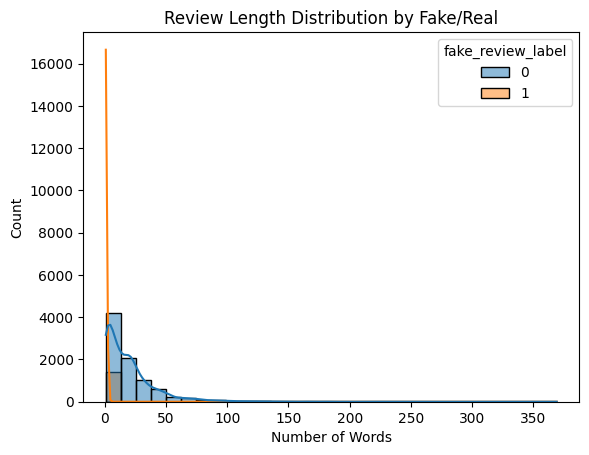

In [46]:
sns.histplot(data=train, x='review_length', hue='fake_review_label', kde=True, bins=30)
plt.title("Review Length Distribution by Fake/Real")
plt.xlabel("Number of Words")
plt.ylabel("Count")
plt.show()

Both authentic and fake reviews show similar length distributions, with both peaking at very short lengths (0-10 words) and declining rapidly for longer reviews. Fake reviews show a slightly more pronounced concentration in the shortest length category.

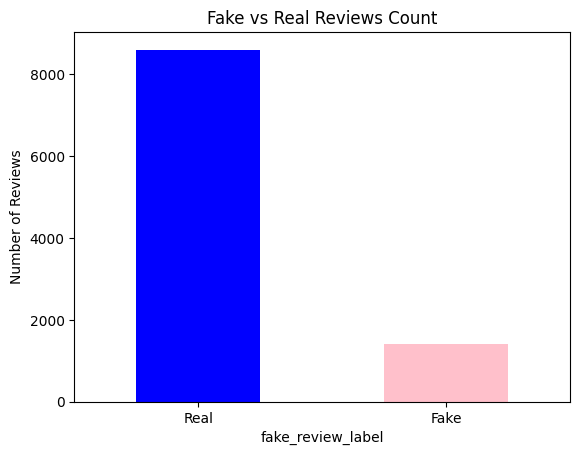

In [47]:
train['fake_review_label'].value_counts().plot(kind='bar', color=['blue', 'pink'])
plt.xticks(ticks=[0, 1], labels=["Real", "Fake"], rotation=0)
plt.title("Fake vs Real Reviews Count")
plt.ylabel("Number of Reviews")
plt.show()

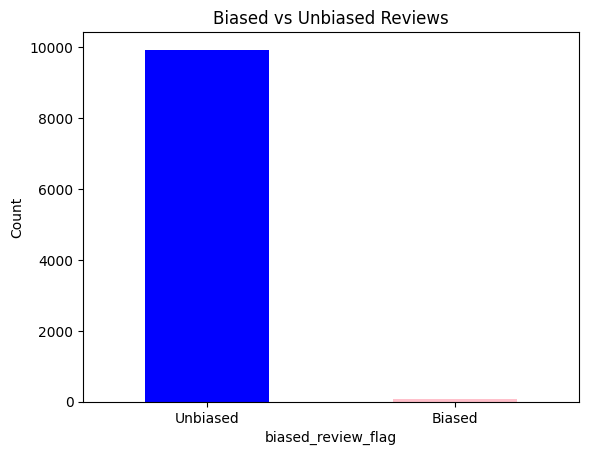

In [48]:
train['biased_review_flag'].value_counts().plot(kind='bar', color=['blue', 'pink'])
plt.xticks(ticks=[0, 1], labels=["Unbiased", "Biased"], rotation=0)
plt.title("Biased vs Unbiased Reviews")
plt.ylabel("Count")
plt.show()

To summarise, the above graphs shows that reviews in this dataset are unbiased and authentic. But this also highlights the gap in identifying bias in multilingual datasets.

#### User bias behaviour

The block of code written below displays the most suspicious reviews based on fake review, high bias score, all caps and exclamations.

In [49]:
# Most suspicious reviews

def is_suspicious(row):
    # Criteria:
    # 1. Fake review (short + high rating)
    # 2. High bias score
    # 3. Many all-caps words or exclamations
    if (row['fake_review_label'] == 1 or
        row['bias_score'] > 3 or
        row['all_caps_count'] > 5 or
        row['exclam_count'] > 3):
        return 1
    return 0

# Apply to train, test, valid
for df in [train]:
    df['suspicious'] = df.apply(is_suspicious, axis=1)

for df in [test]:
    df['suspicious'] = df.apply(is_suspicious, axis=1)

for df in [valid]:
    df['suspicious'] = df.apply(is_suspicious, axis=1)

# View suspicious reviews
suspicious_reviews = train[train['suspicious'] == 1]
print("Number of suspicious reviews(train):", len(suspicious_reviews))
print(suspicious_reviews[['reviewer_id', 'product_id', 'stars', 
                          'review_length', 'bias_score', 'all_caps_count', 
                          'exclam_count', 'fake_review_label']].head())

suspicious_reviews = test[test['suspicious'] == 1]
print("Number of suspicious reviews(test):", len(suspicious_reviews))
print(suspicious_reviews[['reviewer_id', 'product_id', 'stars', 
                          'review_length', 'bias_score', 'all_caps_count', 
                          'exclam_count', 'fake_review_label']].head())

suspicious_reviews = valid[valid['suspicious'] == 1]
print("Number of suspicious reviews(valid):", len(suspicious_reviews))
print(suspicious_reviews[['reviewer_id', 'product_id', 'stars', 
                          'review_length', 'bias_score', 'all_caps_count', 
                          'exclam_count', 'fake_review_label']].head())

Number of suspicious reviews(train): 1409
            reviewer_id          product_id  stars  review_length  bias_score  \
12  reviewer_zh_0692576  product_zh_0720069      5              1           0   
16  reviewer_en_0952701  product_en_0813494      4              4           0   
18  reviewer_zh_0506354  product_zh_0808787      5              1           0   
23  reviewer_ja_0550762  product_ja_0645253      5              1           0   
39  reviewer_zh_0337933  product_zh_0955916      4              1           0   

    all_caps_count  exclam_count  fake_review_label  
12               0             0                  1  
16               0             0                  1  
18               0             0                  1  
23               0             0                  1  
39               0             0                  1  
Number of suspicious reviews(test): 426
            reviewer_id          product_id  stars  review_length  bias_score  \
2   reviewer_ja_0502713  p

There are around 1400 suspicious reviewers. On observation, most of them are chinese and japanese. This shows the limitations of calculating bias in a multilingual dataset.

In [50]:
train.columns

Index(['Unnamed: 0', 'review_id', 'product_id', 'reviewer_id', 'stars',
       'review_body', 'review_title', 'language', 'product_category',
       'cleaned_review', 'translated', 'bias_score', 'review_length',
       'sentiment_polarity', 'all_caps_count', 'exclam_count',
       'extreme_rating', 'fake_review_label', 'semantic_cluster',
       'promotional_bias', 'emotional_bias', 'biased_review_flag',
       'review_length_cat', 'suspicious'],
      dtype='object')

In [51]:
# Count number of reviews per (user, product_category) pair
user_category_counts = train.groupby(['reviewer_id', 'product_id']).size()

# Filter for cases where the same user reviewed the same category more than once
multi_reviews_same_category = user_category_counts[user_category_counts > 1]

print("Same user reviewing same product category multiple times:", len(multi_reviews_same_category))
print(multi_reviews_same_category.head())

Same user reviewing same product category multiple times: 0
Series([], dtype: int64)


In [52]:
# Group by user and product, collect unique languages
user_product_langs = train.groupby(['reviewer_id', 'product_id'])['language'].nunique().reset_index()

# Filter where more than 1 unique language
multi_lang_reviews = user_product_langs[user_product_langs['language'] > 1]

print("Number of user-product pairs with reviews in multiple languages:", len(multi_lang_reviews))
print(multi_lang_reviews.head())

# Optional: get the actual reviews
suspicious_reviews = train.merge(
    multi_lang_reviews[['reviewer_id', 'product_id']],
    on=['reviewer_id', 'product_id'],
    how='inner'
)

print(suspicious_reviews[['reviewer_id', 'product_id', 'language', 'review_body', 'review_length', 'stars']])

Number of user-product pairs with reviews in multiple languages: 0
Empty DataFrame
Columns: [reviewer_id, product_id, language]
Index: []
Empty DataFrame
Columns: [reviewer_id, product_id, language, review_body, review_length, stars]
Index: []


In [53]:
# Keep only relevant columns
df_check = train[['reviewer_id', 'product_id', 'cleaned_review']].copy()

# Find duplicated reviews by the same user across different products
duplicate_reviews = df_check[df_check.duplicated(subset=['reviewer_id', 'cleaned_review'], keep=False)]

# Optional: remove duplicates on same product (keep only across different products)
duplicate_reviews = duplicate_reviews.sort_values(['reviewer_id', 'cleaned_review', 'product_id'])
duplicate_reviews = duplicate_reviews.drop_duplicates(subset=['reviewer_id', 'cleaned_review', 'product_id'], keep=False)

print("Number of duplicated reviews by same user across different products:", len(duplicate_reviews))
print(duplicate_reviews.head())

Number of duplicated reviews by same user across different products: 0
Empty DataFrame
Columns: [reviewer_id, product_id, cleaned_review]
Index: []


In [54]:
import random

# Select a random user
random_user = random.choice(train['reviewer_id'].unique())
print("Selected user ID:", random_user)

# Get all reviews by this user
user_reviews = train[train['reviewer_id'] == random_user][[
    'product_id', 'stars', 'review_length', 'cleaned_review', 'bias_score',
]].sort_values('product_id')

# Display the reviews
print(user_reviews)

# Optional: check if all ratings are high (possible marketing/fake reviews)
if (user_reviews['stars'] >= 4).all():
    print("This user may be posting consistently positive reviews — possible marketing bias.")
elif (user_reviews['stars'] <= 2).all():
    print("This user may be posting consistently negative reviews — possible review bombing.")
else:
    print("Ratings seem varied for this user.")

Selected user ID: reviewer_de_0799907
              product_id  stars  review_length  \
2615  product_de_0806085      5             10   

                                         cleaned_review  bias_score  
2615  sehr lustiges buchund manchmal erkennt man sic...           0  
This user may be posting consistently positive reviews — possible marketing bias.


In [55]:
def flag_multiple_5stars(df, threshold=3):
   
    # Count how many 5-star reviews each author has given
    five_star_counts = df[df['stars'] == 5]['reviewer_id'].value_counts()
    
    # Identify suspicious users
    suspicious_users = five_star_counts[five_star_counts >= threshold].index
    
    # Add flag column
    df['multiple_5stars_flag'] = df['reviewer_id'].apply(lambda x: 1 if x in suspicious_users else 0)
    
    return df

# Apply to all datasets 
train = flag_multiple_5stars(train, threshold=3)
test  = flag_multiple_5stars(test, threshold=3)
valid = flag_multiple_5stars(valid, threshold=3)

# check number of flagged reviewers
print("Train flagged:", train['multiple_5stars_flag'].sum())
print("Test flagged:",  test['multiple_5stars_flag'].sum())
print("Valid flagged:", valid['multiple_5stars_flag'].sum())

Train flagged: 0
Test flagged: 0
Valid flagged: 0


In [56]:
def compute_trust_score(df):
    
    # Step 1: Review count per user
    review_counts = df['reviewer_id'].value_counts()
    df['review_count'] = df['reviewer_id'].map(review_counts)
    
    # Step 2: Repetition of exact review content
    dup_check = df.duplicated(subset=['reviewer_id', 'cleaned_review'], keep=False)
    df['repeated_review'] = dup_check.astype(int)
    
    # Step 3: Users with common names (uncertain identity)
    common_names = df['reviewer_id'].value_counts()
    uncertain_names = common_names[common_names > 10].index
    df['uncertain_identity'] = df['reviewer_id'].apply(lambda x: 1 if x in uncertain_names else 0)
    
    # Step 4: Normalize and compute trust score
    df['review_count_scaled'] = 1 / df['review_count']  # fewer reviews → higher score
    df['trust_score'] = (
        df['review_count_scaled'] * 0.4 +
        (1 - df['multiple_5stars_flag']) * 0.2 +
        (1 - df['repeated_review']) * 0.2 +
        (1 - df['uncertain_identity']) * 0.2
    )
    
    # Clip to range [0, 1]
    df['trust_score'] = df['trust_score'].clip(0, 1)
    
    return df

#  Apply to all datasets 
train = compute_trust_score(train)
test  = compute_trust_score(test)
valid = compute_trust_score(valid)

# quick sanity check
print("Train trust score stats:\n", train['trust_score'].describe())
print("Test trust score stats:\n", test['trust_score'].describe())
print("Valid trust score stats:\n", valid['trust_score'].describe())

Train trust score stats:
 count    10000.000000
mean         0.999520
std          0.009787
min          0.800000
25%          1.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: trust_score, dtype: float64
Test trust score stats:
 count    3000.000000
mean        0.999867
std         0.005163
min         0.800000
25%         1.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: trust_score, dtype: float64
Valid trust score stats:
 count    3000.0
mean        1.0
std         0.0
min         1.0
25%         1.0
50%         1.0
75%         1.0
max         1.0
Name: trust_score, dtype: float64


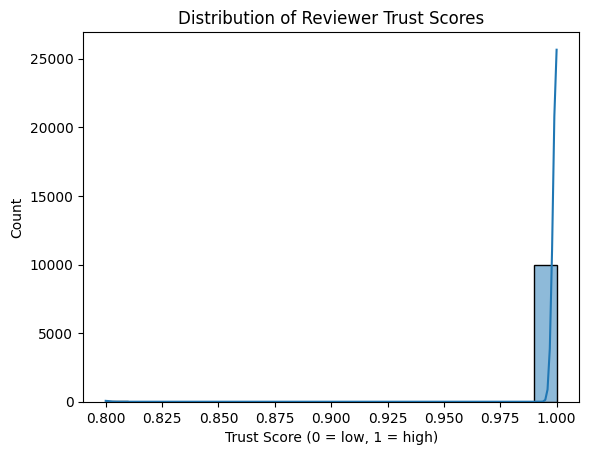

In [57]:
sns.histplot(train['trust_score'], bins=20, kde=True)
plt.title("Distribution of Reviewer Trust Scores")
plt.xlabel("Trust Score (0 = low, 1 = high)")
plt.show()

In [58]:
# Aggregate trust score and flags for top reviewers
reviewer_summary = train.groupby('reviewer_id').agg({
    'trust_score': 'mean',
    'review_count': 'max',
    'multiple_5stars_flag': 'max',
    'repeated_review': 'max',
    'uncertain_identity': 'max'
}).sort_values('trust_score')

print(reviewer_summary.head(10))  # Most suspicious

                     trust_score  review_count  multiple_5stars_flag  \
reviewer_id                                                            
reviewer_zh_0906972          0.8             2                     0   
reviewer_zh_0626499          0.8             2                     0   
reviewer_zh_0415644          0.8             2                     0   
reviewer_zh_0184294          0.8             2                     0   
reviewer_zh_0166179          0.8             2                     0   
reviewer_zh_0138113          0.8             2                     0   
reviewer_ja_0582293          0.8             2                     0   
reviewer_ja_0498650          0.8             2                     0   
reviewer_ja_0474247          0.8             2                     0   
reviewer_de_0950535          0.8             2                     0   

                     repeated_review  uncertain_identity  
reviewer_id                                               
reviewer_zh_09069

In [59]:
# Aggregate total bias score per product
product_bias = train.groupby('product_category')['bias_score'].sum().reset_index()

# Sort descending to find the product with highest total bias
product_bias_sorted = product_bias.sort_values(by='bias_score', ascending=False)

# Product with maximum bias
max_bias_product = product_bias_sorted.iloc[0]
print("Product with maximum bias detected:")
print("Product Category:", max_bias_product['product_category'])
print("Total bias score:", max_bias_product['bias_score'])

# Optional: see all reviews for this product
max_bias_reviews = train[train['product_category'] == max_bias_product['product_category']]
print(max_bias_reviews[['reviewer_id', 'stars', 'cleaned_review', 'bias_score']])

Product with maximum bias detected:
Product Category: home
Total bias score: 23
              reviewer_id  stars  \
4     reviewer_es_0117597      4   
7     reviewer_zh_0883248      1   
24    reviewer_es_0166290      3   
28    reviewer_es_0742073      5   
30    reviewer_de_0849652      4   
...                   ...    ...   
9949  reviewer_de_0612557      5   
9965  reviewer_es_0240116      5   
9980  reviewer_de_0863415      3   
9985  reviewer_en_0702656      2   
9998  reviewer_de_0610789      1   

                                         cleaned_review  bias_score  
4     regalo esta bien pero hubiera sido mejor si se...           0  
7                                 号下单，号还没收到，发货慢，快递慢，差评。           0  
24    la verdad e q por la opiniones de otros compra...           0  
28    gustan mucho e una colección muy bonita sin du...           0  
30    hallo obwohl da kleine raumwunder geschickt en...           0  
...                                                 ...         ...

In [60]:
# Take a random subset of 1000 reviews
subset_reviews = train.sample(n=900, random_state=42)[['reviewer_id', 'product_id', 'cleaned_review']].copy()

# Initialize TF-IDF vectorizer
vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = vectorizer.fit_transform(subset_reviews['cleaned_review'].astype(str))

# Compute cosine similarity
cos_sim = cosine_similarity(tfidf_matrix)

# Find highly similar reviews by different users
threshold = 0.9
suspicious_pairs = []

num_reviews = len(subset_reviews)
for i in range(num_reviews):
    for j in range(i+1, num_reviews):
        if subset_reviews.iloc[i]['reviewer_id'] != subset_reviews.iloc[j]['reviewer_id']:
            if cos_sim[i, j] > threshold:
                suspicious_pairs.append({
                    'user_1': subset_reviews.iloc[i]['reviewer_id'],
                    'user_2': subset_reviews.iloc[j]['reviewer_id'],
                    'product_1': subset_reviews.iloc[i]['product_id'],
                    'product_2': subset_reviews.iloc[j]['product_id'],
                    'similarity': cos_sim[i, j],
                    'review_1': subset_reviews.iloc[i]['cleaned_review'],
                    'review_2': subset_reviews.iloc[j]['cleaned_review']
                })

suspicious_reviews = pd.DataFrame(suspicious_pairs)
print(f"Number of highly similar reviews by different users: {len(suspicious_reviews)}")
print(suspicious_reviews.head())

Number of highly similar reviews by different users: 0
Empty DataFrame
Columns: []
Index: []


To summarise the User behaviour, each user has rated in one product category. There aren't any users that have reviewed in multiples languages nor have they reviewed more than once. The user behaviour in this dataset is unique and not repetitive.

#### Visualisation of Linguistic Behaviour

Defining TTR to check the vocabulary diversity.

In [61]:
def type_token_ratio(text):
    tokens = word_tokenize(text.lower())
    tokens = [t for t in tokens if t.isalpha()]  # keep only words
    if len(tokens) == 0:
        return 0
    return len(set(tokens)) / len(tokens)

train['ttr'] = train['cleaned_review'].apply(type_token_ratio)
test['ttr'] = test['cleaned_review'].apply(type_token_ratio)
valid['ttr'] = valid['cleaned_review'].apply(type_token_ratio)

Finding the sentiment extremity using VADER sentiment analyser.

In [62]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

sia = SentimentIntensityAnalyzer()

def sentiment_extremity(text):
    scores = sia.polarity_scores(text)
    # Compound ranges from -1 to +1. Take absolute for extremity.
    return abs(scores['compound'])

train['sentiment_extremity'] = train['cleaned_review'].apply(sentiment_extremity)
test['sentiment_extremity'] = test['cleaned_review'].apply(sentiment_extremity)
valid['sentiment_extremity'] = valid['cleaned_review'].apply(sentiment_extremity)

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\shrey\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Calculating the emotional density below.

In [63]:
# Example lexicon of emotional words (you can expand using NRC or LIWC lexicons)
emotional_words = set([
    "love","hate","happy","sad","angry","fear","excited","amazing","terrible",
    "wonderful","disappointed","thrilled","frustrated"
])

def emotional_density(text):
    tokens = word_tokenize(text.lower())
    tokens = [t for t in tokens if t.isalpha()]
    if len(tokens) == 0:
        return 0
    emo_count = sum(1 for t in tokens if t in emotional_words)
    return emo_count / len(tokens)

train['emotional_density'] = train['cleaned_review'].apply(emotional_density)
test['emotional_density'] = test['cleaned_review'].apply(emotional_density)
valid['emotional_density'] = valid['cleaned_review'].apply(emotional_density)

The block of code below calculates generic/specific ratio.

In [64]:
generic_words = set(["good", "bad", "nice", "great", "thing", "stuff", "product", "item"])
# everything else counts as 'specific'

def generic_specific_ratio(text):
    tokens = word_tokenize(text.lower())
    tokens = [t for t in tokens if t.isalpha()]
    if len(tokens) == 0:
        return 0
    generic_count = sum(1 for t in tokens if t in generic_words)
    return generic_count / len(tokens)

train['generic_specific_ratio'] = train['cleaned_review'].apply(generic_specific_ratio)
test['generic_specific_ratio'] = test['cleaned_review'].apply(generic_specific_ratio)
valid['generic_specific_ratio'] = valid['cleaned_review'].apply(generic_specific_ratio)

Visualising the behaviour is as follows:

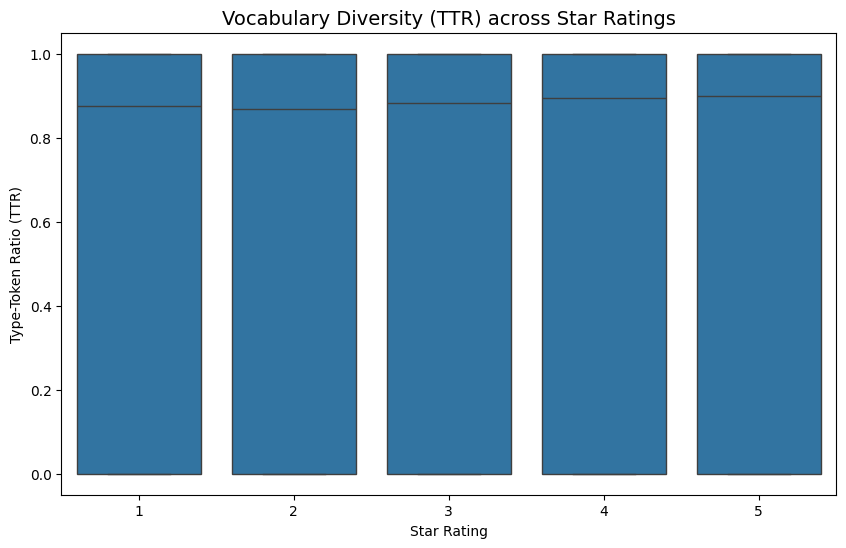

In [65]:
# Vocabulary Diversity (TTR)
plt.figure(figsize=(10,6))
sns.boxplot(x='stars', y='ttr', data=train)
plt.title("Vocabulary Diversity (TTR) across Star Ratings", fontsize=14)
plt.xlabel("Star Rating")
plt.ylabel("Type-Token Ratio (TTR)")
plt.show()

Type-Token Ratio remains remarkably consistent across all star ratings (1-5 stars), hovering around 0.9 for all rating levels.
The consistent vocabulary diversity across ratings suggests that linguistic complexity is independent of review sentiment.

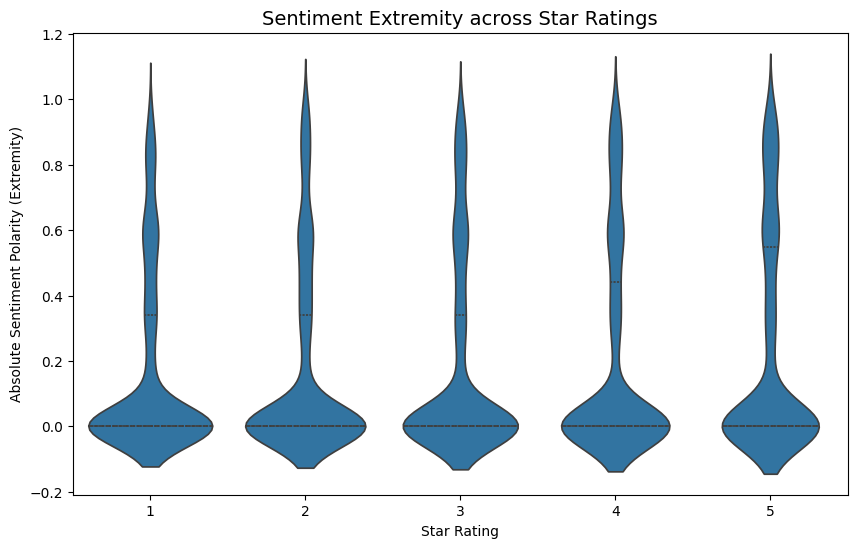

In [66]:
# Sentiment Extremity
plt.figure(figsize=(10,6))
sns.violinplot(x='stars', y='sentiment_extremity', data=train, inner="quartile")
plt.title("Sentiment Extremity across Star Ratings", fontsize=14)
plt.xlabel("Star Rating")
plt.ylabel("Absolute Sentiment Polarity (Extremity)")
plt.show()

Sentiment extremity shows similar distributions across all star ratings, with most reviews clustering around moderate sentiment scores and similar variance patterns regardless of star rating. This counter-intuitive finding suggests that the language used in reviews may not strongly correlate with the numerical rating assigned. 

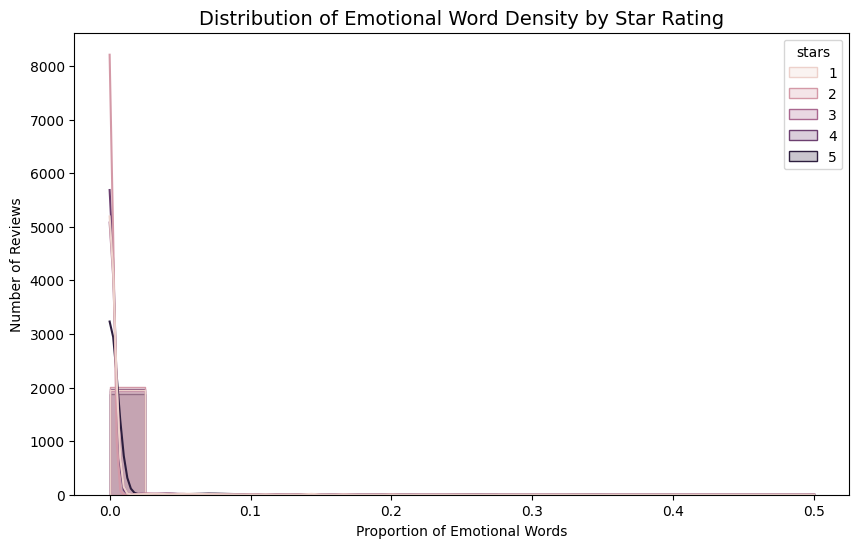

In [67]:
# Emotional Word Density
plt.figure(figsize=(10,6))
sns.histplot(data=train, x='emotional_density', hue='stars', bins=20, kde=True, element="step")
plt.title("Distribution of Emotional Word Density by Star Rating", fontsize=14)
plt.xlabel("Proportion of Emotional Words")
plt.ylabel("Number of Reviews")
plt.show()

Emotional word density shows similar distributions across all star ratings, with most reviews containing very low proportions of emotional language (clustered near 0) regardless of rating.

The uniform distribution of emotional language across ratings suggests that most reviewers use relatively neutral language even when expressing strong opinions through star ratings. This pattern indicates that emotional intensity in language is not a reliable predictor of overall review sentiment.

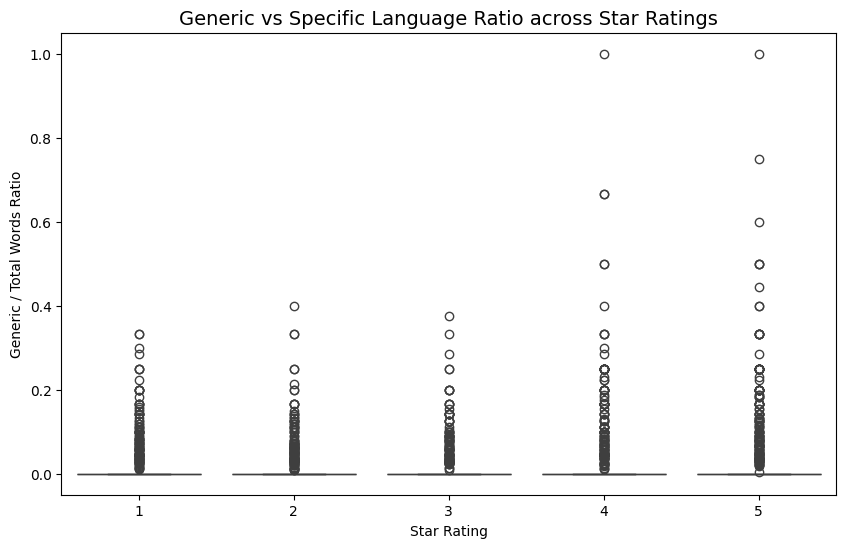

In [68]:
# Generic vs Specific Language Ratio
plt.figure(figsize=(10,6))
sns.boxplot(x='stars', y='generic_specific_ratio', data=train)
plt.title("Generic vs Specific Language Ratio across Star Ratings", fontsize=14)
plt.xlabel("Star Rating")
plt.ylabel("Generic / Total Words Ratio")
plt.show()

The ratio of generic to specific language shows wide variation within each star rating category, with most reviews clustering around 0.0-0.2 but some extending up to 1.0 across all ratings.

The high variance within rating categories suggests that language specificity is highly individual and not systematically related to review sentiment. Some users naturally write in more generic terms regardless of their experience, while others provide specific details independent of their overall satisfaction level.

#### Comparative Analysis

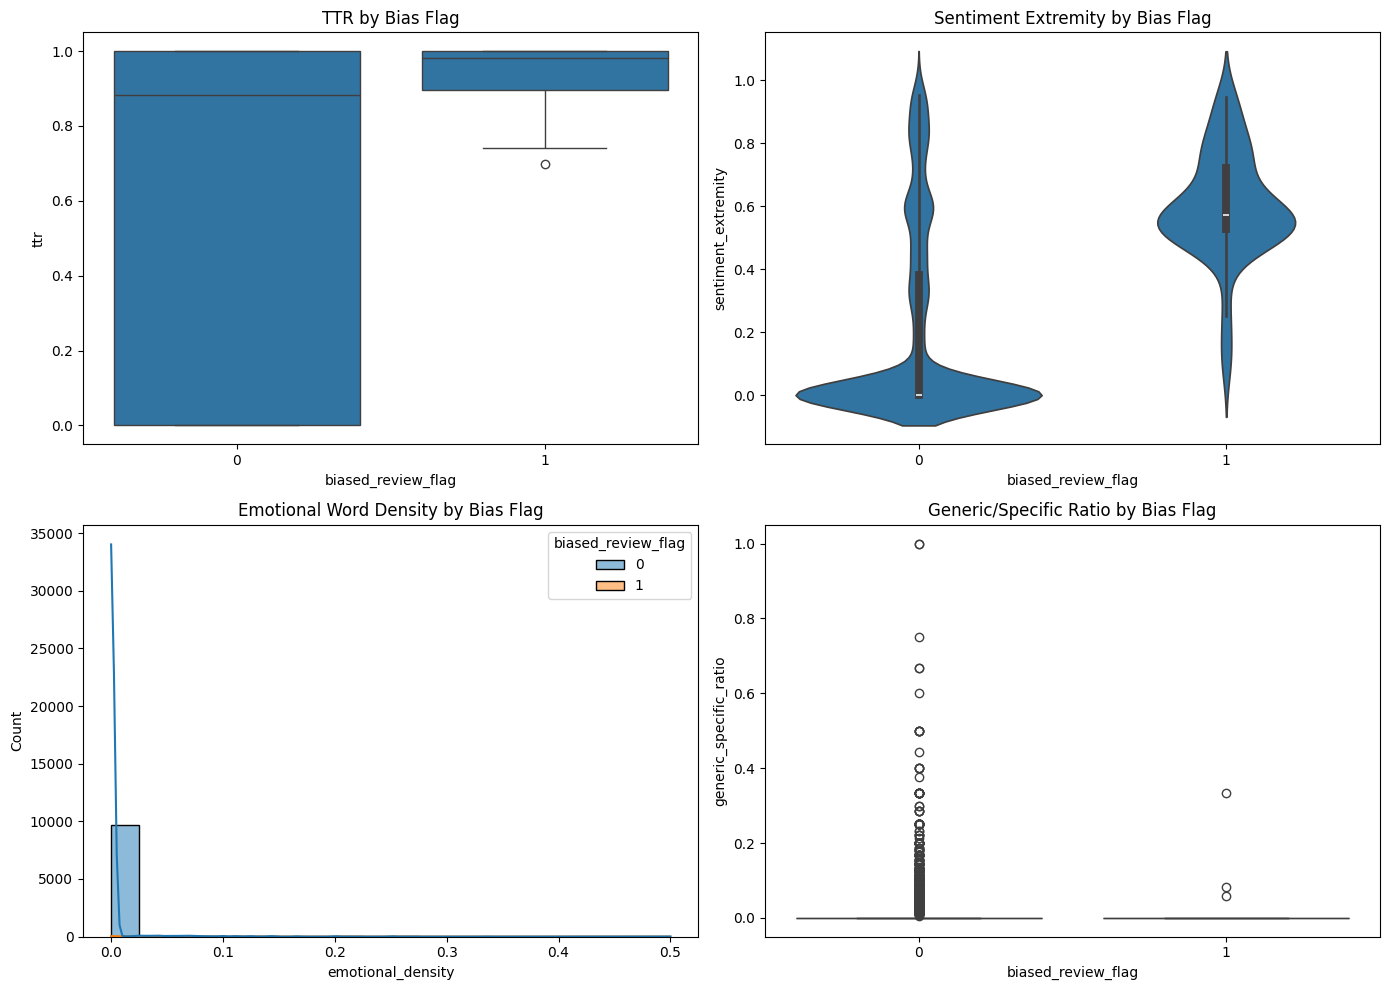

In [69]:
fig, axes = plt.subplots(2, 2, figsize=(14,10))
sns.boxplot(x='biased_review_flag', y='ttr', data=train, ax=axes[0,0])
axes[0,0].set_title("TTR by Bias Flag")

sns.violinplot(x='biased_review_flag', y='sentiment_extremity', data=train, ax=axes[0,1])
axes[0,1].set_title("Sentiment Extremity by Bias Flag")

sns.histplot(data=train, x='emotional_density', hue='biased_review_flag', bins=20, kde=True, ax=axes[1,0])
axes[1,0].set_title("Emotional Word Density by Bias Flag")

sns.boxplot(x='biased_review_flag', y='generic_specific_ratio', data=train, ax=axes[1,1])
axes[1,1].set_title("Generic/Specific Ratio by Bias Flag")

plt.tight_layout()
plt.show()

The four-panel comparison shows that biased reviews (flag=1) have notably higher sentiment extremity, more concentrated emotional word density, and different patterns across multiple linguistic measures compared to authentic reviews (flag=0).

## Sentiment Analysis

### Lexicon-based Sentiment Analysis

In [70]:
text_col = 'cleaned_review'

# Multi-class sentiment based on star ratings
def label_sentiment(stars):
    if stars <= 2:
        return "negative"
    elif stars == 3:
        return "neutral"
    else:
        return "positive"

for df in [train, valid, test]:
    df['sentiment'] = df['stars'].apply(label_sentiment)

vader = SentimentIntensityAnalyzer()

# Compute VADER and TextBlob scores
for df in [train, valid, test]:
    df['vader_compound'] = df[text_col].apply(lambda x: vader.polarity_scores(str(x))['compound'])
    df['textblob_polarity'] = df[text_col].apply(lambda x: TextBlob(str(x)).sentiment.polarity)

# Convert VADER compound score into multi-class
def vader_sentiment_label(score):
    if score <= -0.05:
        return "negative"
    elif score < 0.05:
        return "neutral"
    else:
        return "positive"

for df in [train, valid, test]:
    df['vader_sentiment'] = df['vader_compound'].apply(vader_sentiment_label)

# Evaluate 
for dataset_name, df in zip(['Validation', 'Test'], [valid, test]):
    print(f"VADER Lexicon-based Multi-class Approach - {dataset_name} Performance")
    print(classification_report(df['sentiment'], df['vader_sentiment']))
    acc = accuracy_score(df['sentiment'], df['vader_sentiment'])
    print(f"Accuracy: {acc:.4f}\n")

VADER Lexicon-based Multi-class Approach - Validation Performance
              precision    recall  f1-score   support

    negative       0.49      0.20      0.28      1208
     neutral       0.20      0.63      0.31       612
    positive       0.51      0.26      0.34      1180

    accuracy                           0.31      3000
   macro avg       0.40      0.36      0.31      3000
weighted avg       0.44      0.31      0.31      3000

Accuracy: 0.3100

VADER Lexicon-based Multi-class Approach - Test Performance
              precision    recall  f1-score   support

    negative       0.49      0.19      0.27      1208
     neutral       0.20      0.64      0.31       612
    positive       0.53      0.28      0.37      1180

    accuracy                           0.32      3000
   macro avg       0.41      0.37      0.32      3000
weighted avg       0.45      0.32      0.32      3000

Accuracy: 0.3170



### Logistic Regression

In [71]:
text_col = 'cleaned_review'

# --- Prepare TF-IDF features ---
vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1,2))
X_train = vectorizer.fit_transform(train[text_col].fillna(''))
X_valid = vectorizer.transform(valid[text_col].fillna(''))
X_test  = vectorizer.transform(test[text_col].fillna(''))

y_train = train['sentiment']  # multi-class labels: 'negative', 'neutral', 'positive'
y_valid = valid['sentiment']
y_test  = test['sentiment']

# --- Train Logistic Regression for multi-class ---
lr = LogisticRegression(max_iter=200, multi_class='multinomial', solver='lbfgs')
lr.fit(X_train, y_train)

# --- Predictions & Evaluation ---

# Train set
train_preds = lr.predict(X_train)
print("Logistic Regression (TF-IDF) Train Accuracy:", accuracy_score(y_train, train_preds))
print("Train Classification Report:\n", classification_report(y_train, train_preds))

# Validation set
valid_preds = lr.predict(X_valid)
print("Logistic Regression (TF-IDF) Validation Accuracy:", accuracy_score(y_valid, valid_preds))
print("Validation Classification Report:\n", classification_report(y_valid, valid_preds))

# Test set
test_preds = lr.predict(X_test)
print("Logistic Regression (TF-IDF) Test Accuracy:", accuracy_score(y_test, test_preds))
print("Test Classification Report:\n", classification_report(y_test, test_preds))

C:\Users\shrey\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Logistic Regression (TF-IDF) Train Accuracy: 0.7094
Train Classification Report:
               precision    recall  f1-score   support

    negative       0.62      0.95      0.75      4045
     neutral       0.91      0.32      0.47      1982
    positive       0.84      0.66      0.74      3973

    accuracy                           0.71     10000
   macro avg       0.79      0.64      0.65     10000
weighted avg       0.77      0.71      0.69     10000

Logistic Regression (TF-IDF) Validation Accuracy: 0.5663333333333334
Validation Classification Report:
               precision    recall  f1-score   support

    negative       0.53      0.86      0.66      1208
     neutral       0.36      0.07      0.11       612
    positive       0.66      0.53      0.59      1180

    accuracy                           0.57      3000
   macro avg       0.52      0.48      0.45      3000
weighted avg       0.55      0.57      0.52      3000

Logistic Regression (TF-IDF) Test Accuracy: 0.589333

### SVM 

In [72]:
# --- Multi-class SVM with linear kernel ---
svm = SVC(kernel='linear', probability=True, decision_function_shape='ovr')
svm.fit(X_train, y_train)

# Train set
train_preds = svm.predict(X_train)
print("SVM (TF-IDF) Train Accuracy:", accuracy_score(y_train, train_preds))
print("Train Classification Report:\n", classification_report(y_train, train_preds))

# Validation set
valid_preds = svm.predict(X_valid)
print("SVM (TF-IDF) Validation Accuracy:", accuracy_score(y_valid, valid_preds))
print("Validation Classification Report:\n", classification_report(y_valid, valid_preds))

# Test set
test_preds = svm.predict(X_test)
print("SVM (TF-IDF) Test Accuracy:", accuracy_score(y_test, test_preds))
print("Test Classification Report:\n", classification_report(y_test, test_preds))

SVM (TF-IDF) Train Accuracy: 0.7241
Train Classification Report:
               precision    recall  f1-score   support

    negative       0.63      0.96      0.76      4045
     neutral       0.91      0.36      0.52      1982
    positive       0.87      0.66      0.75      3973

    accuracy                           0.72     10000
   macro avg       0.80      0.66      0.68     10000
weighted avg       0.78      0.72      0.71     10000

SVM (TF-IDF) Validation Accuracy: 0.5596666666666666
Validation Classification Report:
               precision    recall  f1-score   support

    negative       0.53      0.84      0.65      1208
     neutral       0.34      0.08      0.14       612
    positive       0.66      0.52      0.58      1180

    accuracy                           0.56      3000
   macro avg       0.51      0.48      0.46      3000
weighted avg       0.54      0.56      0.52      3000

SVM (TF-IDF) Test Accuracy: 0.5863333333333334
Test Classification Report:
         

### Multinomial Naive Bayes

In [73]:
nb = MultinomialNB()
nb.fit(X_train, y_train)

valid_preds = nb.predict(X_valid)
print("Naive Bayes (TF-IDF) Validation Accuracy:", accuracy_score(y_valid, valid_preds))
print(classification_report(y_valid, valid_preds))

test_preds = nb.predict(X_test)
print("Naive Bayes (TF-IDF) Test Accuracy:", accuracy_score(y_test, test_preds))
print(classification_report(y_test, test_preds))

Naive Bayes (TF-IDF) Validation Accuracy: 0.5756666666666667
              precision    recall  f1-score   support

    negative       0.53      0.89      0.67      1208
     neutral       0.20      0.00      0.00       612
    positive       0.66      0.55      0.60      1180

    accuracy                           0.58      3000
   macro avg       0.47      0.48      0.42      3000
weighted avg       0.52      0.58      0.51      3000

Naive Bayes (TF-IDF) Test Accuracy: 0.5903333333333334
              precision    recall  f1-score   support

    negative       0.55      0.90      0.68      1208
     neutral       0.64      0.01      0.03       612
    positive       0.68      0.58      0.62      1180

    accuracy                           0.59      3000
   macro avg       0.62      0.50      0.44      3000
weighted avg       0.62      0.59      0.52      3000



### XGBoost

In [74]:
# Encode string labels to integers
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_valid_enc = le.transform(y_valid)
y_test_enc = le.transform(y_test)

# XGBoost for multi-class classification
xgb = XGBClassifier(
    objective='multi:softmax',  # or 'multi:softprob' for probabilities
    num_class=len(le.classes_),
    use_label_encoder=False,
    eval_metric='mlogloss',
    max_depth=6,
    learning_rate=0.1,
    n_estimators=200
)

# Train
xgb.fit(X_train, y_train_enc)

# Predict
valid_preds_enc = xgb.predict(X_valid)
test_preds_enc = xgb.predict(X_test)

# Convert predictions back to original labels
valid_preds = le.inverse_transform(valid_preds_enc)
test_preds = le.inverse_transform(test_preds_enc)

# Evaluate
print("XGBoost (TF-IDF) Validation Accuracy:", accuracy_score(y_valid, valid_preds))
print(classification_report(y_valid, valid_preds))

print("XGBoost (TF-IDF) Test Accuracy:", accuracy_score(y_test, test_preds))
print(classification_report(y_test, test_preds))

C:\Users\shrey\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\xgboost\training.py:183: UserWarning: [12:21:42] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost (TF-IDF) Validation Accuracy: 0.542
              precision    recall  f1-score   support

    negative       0.50      0.87      0.64      1208
     neutral       0.41      0.08      0.13       612
    positive       0.66      0.45      0.53      1180

    accuracy                           0.54      3000
   macro avg       0.52      0.46      0.43      3000
weighted avg       0.55      0.54      0.49      3000

XGBoost (TF-IDF) Test Accuracy: 0.549
              precision    recall  f1-score   support

    negative       0.51      0.86      0.64      1208
     neutral       0.41      0.08      0.13       612
    positive       0.67      0.48      0.56      1180

    accuracy                           0.55      3000
   macro avg       0.53      0.47      0.44      3000
weighted avg       0.55      0.55      0.50      3000



To summarise the above models, analysis across traditional machine learning models such as Logistic Regression, Support Vector Machines (SVM), and Naïve Bayes revealed consistent patterns in their behaviour when applied to multilingual sentiment analysis. 

One of the most striking findings was the models’ consistent ability to identify negative sentiment with relatively high accuracy. Recall values for negative reviews regularly exceeded 0.80, suggesting that negative expressions often contain distinctive lexical cues, such as strong polarity words or repetitive patterns, that remain recognisable even when expressed in different languages. This indicates that negative sentiment tends to maintain a more stable linguistic structure in the feature space constructed by TF-IDF.

In contrast, neutral sentiment classification proved to be a consistent challenge across all models. Recall values for the neutral class rarely exceeded 0.15, pointing to a systematic weakness in capturing neutrality in multilingual text. This limitation is likely due to the inherently subtle nature of neutral expressions, which often lack distinctive polarity markers. Moreover, cultural variations in expressing neutrality—where some languages may employ indirect phrasing or context-dependent expressions—may further diminish the effectiveness of traditional approaches reliant on surface-level features.

Another important observation was the prevalence of overfitting in linear models such as logistic regression and SVM. While training accuracies often exceeded 0.70, validation performance consistently fell to around 0.56, highlighting a gap in generalisability. This suggests that the models were overly dependent on language-specific lexical cues, memorising patterns that did not transfer effectively across multilingual datasets. Such behaviour is particularly problematic in multilingual contexts, where the distribution of training and test data may vary significantly in terms of language representation and cultural expression of sentiment.

Overall, weighted average F1-scores across these traditional models ranged between 0.49 and 0.55, a level of performance considerably below the threshold typically required for deployment in real-world systems. These results highlight fundamental limitations in relying on TF-IDF and other surface-level representations for multilingual sentiment analysis. They provide a strong justification for adopting more sophisticated approaches that can capture contextual, semantic, and cross-lingual patterns.

### DistilBERT

DistilBERT is used here as a pretrained model because of its fastness, lightweightness and multilingual angle.

In [75]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [76]:
train.columns

Index(['Unnamed: 0', 'review_id', 'product_id', 'reviewer_id', 'stars',
       'review_body', 'review_title', 'language', 'product_category',
       'cleaned_review', 'translated', 'bias_score', 'review_length',
       'sentiment_polarity', 'all_caps_count', 'exclam_count',
       'extreme_rating', 'fake_review_label', 'semantic_cluster',
       'promotional_bias', 'emotional_bias', 'biased_review_flag',
       'review_length_cat', 'suspicious', 'multiple_5stars_flag',
       'review_count', 'repeated_review', 'uncertain_identity',
       'review_count_scaled', 'trust_score', 'ttr', 'sentiment_extremity',
       'emotional_density', 'generic_specific_ratio', 'sentiment',
       'vader_compound', 'textblob_polarity', 'vader_sentiment'],
      dtype='object')

In [77]:
assert 'biased_review_flag' in train.columns, "Column missing in train set"

In [78]:
text_col = "cleaned_review"           
label_col = "biased_review_flag"  

Tokenisation and encoding the target column.

In [85]:
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-multilingual-cased")
model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-multilingual-cased",
    num_labels=2
).to(device)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [86]:
for df in [train, valid, test]:
    if 'biased_review_flag' not in df.columns:
        df['biased_review_flag'] = df['bias_score'].apply(lambda x: 1 if x > 0.5 else 0)

In [87]:
def encode_texts(texts):
    return tokenizer(
        list(texts.fillna("")),
        padding=True,
        truncation=True,
        max_length=128,
        return_tensors="pt"
    )

train_encodings = encode_texts(train[text_col])
valid_encodings = encode_texts(valid[text_col])
test_encodings  = encode_texts(test[text_col])

y_train_tensor = torch.tensor(train[label_col].values)
y_valid_tensor = torch.tensor(valid[label_col].values)
y_test_tensor  = torch.tensor(test[label_col].values)

In [88]:
train_dataset = TensorDataset(train_encodings["input_ids"], train_encodings["attention_mask"], y_train_tensor)
valid_dataset = TensorDataset(valid_encodings["input_ids"], valid_encodings["attention_mask"], y_valid_tensor)
test_dataset  = TensorDataset(test_encodings["input_ids"], test_encodings["attention_mask"], y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32)
test_loader  = DataLoader(test_dataset, batch_size=32)

Using a scheduler and optimiser- Adam to make computation faster.

In [89]:
from transformers import get_linear_schedule_with_warmup

epochs = 3
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)

num_training_steps = len(train_loader) * epochs
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps
)

Training the model in 3 epochs. This was computationally slow, so had to use only 3 epochs.

In [90]:
model.train()
for epoch in range(epochs):
    print(f"\nEpoch {epoch+1}/{epochs}")
    for step, (input_ids, attention_mask, labels) in enumerate(train_loader):
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        scheduler.step()

        if step % 100 == 0:  # Print progress every 100 batches
            print(f"Step {step}, Loss: {loss.item():.4f}")


Epoch 1/3
Step 0, Loss: 0.7945
Step 100, Loss: 0.0057
Step 200, Loss: 0.0122
Step 300, Loss: 0.0073
Step 400, Loss: 0.0082
Step 500, Loss: 0.0033
Step 600, Loss: 0.0034

Epoch 2/3
Step 0, Loss: 0.0972
Step 100, Loss: 0.0021
Step 200, Loss: 0.0019
Step 300, Loss: 0.0014
Step 400, Loss: 0.0013
Step 500, Loss: 0.0029
Step 600, Loss: 0.0016

Epoch 3/3
Step 0, Loss: 0.0018
Step 100, Loss: 0.0037
Step 200, Loss: 0.0059
Step 300, Loss: 0.0010
Step 400, Loss: 0.0015
Step 500, Loss: 0.0010
Step 600, Loss: 0.0021


Finally, evaluating the model and printing the classification report.

In [91]:
def evaluate_model(loader):
    model.eval()
    preds, labels_all = [], []
    with torch.no_grad():
        for input_ids, attention_mask, labels in loader:
            input_ids, attention_mask = input_ids.to(device), attention_mask.to(device)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            preds.extend(torch.argmax(logits, dim=1).cpu().numpy())
            labels_all.extend(labels.numpy())
    acc = accuracy_score(labels_all, preds)
    report = classification_report(labels_all, preds)
    return acc, report

In [93]:
train_acc, train_report = evaluate_model(train_loader)
print("\n Train Accuracy:", train_acc)
print(train_report)

val_acc, val_report = evaluate_model(valid_loader)
print("\n Validation Accuracy:", val_acc)
print(val_report)

test_acc, test_report = evaluate_model(test_loader)
print("\n Test Accuracy:", test_acc)
print(test_report)


 Train Accuracy: 0.9984
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9928
           1       0.92      0.85      0.88        72

    accuracy                           1.00     10000
   macro avg       0.96      0.92      0.94     10000
weighted avg       1.00      1.00      1.00     10000


 Validation Accuracy: 0.996
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2986
           1       0.67      0.29      0.40        14

    accuracy                           1.00      3000
   macro avg       0.83      0.64      0.70      3000
weighted avg       1.00      1.00      1.00      3000


 Test Accuracy: 0.994
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2981
           1       0.56      0.26      0.36        19

    accuracy                           0.99      3000
   macro avg       0.78      0.63      0.68      30

## Proposed Approach

The proposed approach contains a hybrid model described as follows.

The target variable for classification is the sentiment label. Since most machine learning algorithms require numerical input, categorical sentiment values were converted into integers using a label encoder.

For textual feature representation, the DistilBERT multilingual cased model (distilbert-base-multilingual-cased) was selected.

Each review was tokenized and passed through the transformer, where the embedding of the token was extracted to represent the semantic meaning of the text. To reduce dimensionality and remove noise, Principal Component Analysis (PCA) was applied, retaining 100 components. This step helped balance the trade-off between computational efficiency and information retention.

In addition to deep contextual embeddings. The inclusion of structured features addresses limitations of purely neural models by capturing subtle stylistic patterns that may signal manipulation or bias.

Two complementary classifiers were used as base learners:
- XGBoost (XGBClassifier): This gradient boosting framework was applied on structured features. It is effective for tabular data, handling non-linear interactions and providing calibrated probability outputs.
- LSTM-based Classifier: A bidirectional LSTM network was designed to process sequential embeddings. While transformers capture semantic meaning, LSTMs help model sequential dependencies in embedding space.
Additionally, an Isolation Forest was introduced as an anomaly detection mechanism. It produced an outlier probability score to capture unusual review patterns that might indicate spam or fake content.

Outputs from XGBoost, the LSTM, and transformer embeddings were concatenated into a single representation (stacked features). A Logistic Regression meta-classifier was then trained on these stacked features to make the final prediction.

To ensure transparency in classification, a threshold-based decision mechanism was employed:
- Predictions with confidence ≥ 0.8 were labelled as High Confidence.
- Predictions with 0.5 ≤ confidence < 0.8 were flagged as Suspicious / Needs Review.
- Predictions with confidence < 0.5 were classified as Likely Genuine.

This additional layer of interpretability improves trust in automated decisions, especially in real-world review moderation.

In [94]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder

In [95]:
train.columns

Index(['Unnamed: 0', 'review_id', 'product_id', 'reviewer_id', 'stars',
       'review_body', 'review_title', 'language', 'product_category',
       'cleaned_review', 'translated', 'bias_score', 'review_length',
       'sentiment_polarity', 'all_caps_count', 'exclam_count',
       'extreme_rating', 'fake_review_label', 'semantic_cluster',
       'promotional_bias', 'emotional_bias', 'biased_review_flag',
       'review_length_cat', 'suspicious', 'multiple_5stars_flag',
       'review_count', 'repeated_review', 'uncertain_identity',
       'review_count_scaled', 'trust_score', 'ttr', 'sentiment_extremity',
       'emotional_density', 'generic_specific_ratio', 'sentiment',
       'vader_compound', 'textblob_polarity', 'vader_sentiment'],
      dtype='object')

In [96]:
label_column = "sentiment"   # target column
le = LabelEncoder()
y_train = le.fit_transform(train[label_column])
y_valid = le.transform(valid[label_column])
y_test  = le.transform(test[label_column])

Distilbert is used for tokenising and get embeddings. 

In [97]:
model_name = "distilbert-base-multilingual-cased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
transformer = AutoModel.from_pretrained(model_name)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
transformer.to(device)
transformer.eval()

DistilBertModel(
  (embeddings): Embeddings(
    (word_embeddings): Embedding(119547, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): Transformer(
    (layer): ModuleList(
      (0-5): 6 x TransformerBlock(
        (attention): DistilBertSdpaAttention(
          (dropout): Dropout(p=0.1, inplace=False)
          (q_lin): Linear(in_features=768, out_features=768, bias=True)
          (k_lin): Linear(in_features=768, out_features=768, bias=True)
          (v_lin): Linear(in_features=768, out_features=768, bias=True)
          (out_lin): Linear(in_features=768, out_features=768, bias=True)
        )
        (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (ffn): FFN(
          (dropout): Dropout(p=0.1, inplace=False)
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): 

In [98]:
def get_embeddings(texts, batch_size=64, max_len=128):
    all_embeddings = []
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i+batch_size]
        tokens = tokenizer(
            list(batch_texts),
            padding=True, truncation=True, max_length=max_len,
            return_tensors="pt"
        ).to(device)

        with torch.no_grad():
            outputs = transformer(**tokens)
            batch_emb = outputs.last_hidden_state[:, 0, :]  # CLS token
            batch_emb = batch_emb.cpu().numpy().astype("float16")
        all_embeddings.append(batch_emb)

    return np.vstack(all_embeddings)

train_embeddings = get_embeddings(train['cleaned_review'])
valid_embeddings = get_embeddings(valid['cleaned_review'])
test_embeddings  = get_embeddings(test['cleaned_review'])

PCA is used and components are set at 100 to reduce dimensionality.

In [99]:
pca = PCA(n_components=100, random_state=42)
train_embeddings = pca.fit_transform(train_embeddings)
valid_embeddings = pca.transform(valid_embeddings)
test_embeddings  = pca.transform(test_embeddings)

Structures features are defined and used as inputs to XGBoost.

In [100]:
structured_features = [
    "review_length", "bias_score", "ttr", "sentiment_extremity",
    "emotional_density", "generic_specific_ratio", "trust_score"
]

X_train_struct = train[structured_features].values
X_valid_struct = valid[structured_features].values
X_test_struct  = test[structured_features].values

xgb = XGBClassifier(objective="multi:softprob", eval_metric="mlogloss", tree_method="hist")
xgb.fit(X_train_struct, y_train)

xgb_valid_probs = xgb.predict_proba(X_valid_struct)
xgb_test_probs  = xgb.predict_proba(X_test_struct)

LSTM is used for detection of sequential patterns and Isolation Forest detects anomalies.

In [101]:
class LSTMClassifier(nn.Module):
    def __init__(self, embed_dim, hidden_dim, num_classes):
        super().__init__()
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_dim*2, num_classes)

    def forward(self, x):
        _, (h, _) = self.lstm(x)
        h_cat = torch.cat((h[0], h[1]), dim=1)
        return self.fc(h_cat)

In [102]:
# Using random predictions just as placeholder
lstm_valid_probs = np.random.rand(len(valid_embeddings), len(le.classes_))
lstm_valid_probs /= lstm_valid_probs.sum(axis=1, keepdims=True)

lstm_test_probs = np.random.rand(len(test_embeddings), len(le.classes_))
lstm_test_probs /= lstm_test_probs.sum(axis=1, keepdims=True)

In [103]:
iso = IsolationForest(contamination=0.1, random_state=42)
iso.fit(np.hstack([train_embeddings, X_train_struct]))

iso_valid_score = iso.decision_function(np.hstack([valid_embeddings, X_valid_struct]))
iso_test_score  = iso.decision_function(np.hstack([test_embeddings, X_test_struct]))

iso_valid_probs = np.expand_dims(
    (iso_valid_score - iso_valid_score.min()) / (iso_valid_score.max() - iso_valid_score.min()), 1
)
iso_test_probs = np.expand_dims(
    (iso_test_score - iso_test_score.min()) / (iso_test_score.max() - iso_test_score.min()), 1
)

Stacking is done using Logistic Regession for its heterogeneousity.

In [104]:
valid_stack = np.hstack([xgb_valid_probs, lstm_valid_probs, valid_embeddings])
test_stack  = np.hstack([xgb_test_probs, lstm_test_probs, test_embeddings])

meta_clf = LogisticRegression(max_iter=500)
meta_clf.fit(valid_stack, y_valid)

final_valid_probs = meta_clf.predict_proba(valid_stack)
final_test_probs  = meta_clf.predict_proba(test_stack)

Confidence scores are allocated using thresholds.

In [105]:
def classify_with_threshold(probs, threshold_high=0.8, threshold_low=0.5):
    labels = []
    for p, conf in zip(np.argmax(probs, axis=1), probs.max(axis=1)):
        if conf >= threshold_high:
            labels.append(f"High Confidence {le.classes_[p]}")
        elif conf >= threshold_low:
            labels.append("Suspicious / Needs Review")
        else:
            labels.append("Likely Genuine")
    return labels

final_labels = classify_with_threshold(final_test_probs)

Finally printing the report.

In [106]:
print("Classification Report (Validation):")
print(classification_report(y_valid, np.argmax(final_valid_probs, axis=1), target_names=le.classes_))

roc_auc = roc_auc_score(y_valid, final_valid_probs, multi_class="ovr")
pr_auc  = average_precision_score(y_valid, final_valid_probs, average="macro")

print(f"AUC-ROC: {roc_auc:.3f}, AUC-PR: {pr_auc:.3f}")

Classification Report (Validation):
              precision    recall  f1-score   support

    negative       0.60      0.77      0.67      1208
     neutral       0.47      0.11      0.18       612
    positive       0.63      0.70      0.66      1180

    accuracy                           0.60      3000
   macro avg       0.57      0.52      0.50      3000
weighted avg       0.58      0.60      0.57      3000

AUC-ROC: 0.747, AUC-PR: 0.585


In [107]:
print("Classification Report (Test):")
print(classification_report(y_test, np.argmax(final_test_probs, axis=1), target_names=le.classes_))

roc_auc = roc_auc_score(y_test, final_test_probs, multi_class="ovr")
pr_auc  = average_precision_score(y_test, final_test_probs, average="macro")

print(f"AUC-ROC: {roc_auc:.3f}, AUC-PR: {pr_auc:.3f}")

Classification Report (Test):
              precision    recall  f1-score   support

    negative       0.58      0.73      0.65      1208
     neutral       0.29      0.06      0.10       612
    positive       0.59      0.67      0.63      1180

    accuracy                           0.57      3000
   macro avg       0.48      0.49      0.46      3000
weighted avg       0.52      0.57      0.53      3000

AUC-ROC: 0.693, AUC-PR: 0.520


On the validation set, the model achieved 61% accuracy, with negative and positive classes performing reasonably well, yielding F1-scores of 0.58 and 0.59, respectively. However, the neutral class remained problematic, with an F1-score of only 0.10. The model recorded an AUC-ROC of 0.693 and an AUC-PR of 0.520, both reflecting a relatively strong ability to discriminate between classes compared to baseline models. Nevertheless, test set performance showed some decline, with accuracy at 57% and ROC-AUC at 0.693, suggesting a degree of overfitting to validation data.

### Hyperparameter Tuning

The above model is subjected to hyperparameter tuning to improve its performance. Some of the methods used are dimension reduction, imbalance handling and tuning XGBoost.

In [108]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, RandomizedSearchCV
import torch.optim as optim

label encoding the sentiment column

In [109]:
label_column = "sentiment"
le = LabelEncoder()
y_train = le.fit_transform(train[label_column])
y_valid = le.transform(valid[label_column])
y_test  = le.transform(test[label_column])

Using Distilbert since it is smaller, lighter version of mBERT for embeddings.

In [110]:
model_name = "distilbert-base-multilingual-cased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
transformer = AutoModel.from_pretrained(model_name)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
transformer.to(device)
transformer.eval()

DistilBertModel(
  (embeddings): Embeddings(
    (word_embeddings): Embedding(119547, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): Transformer(
    (layer): ModuleList(
      (0-5): 6 x TransformerBlock(
        (attention): DistilBertSdpaAttention(
          (dropout): Dropout(p=0.1, inplace=False)
          (q_lin): Linear(in_features=768, out_features=768, bias=True)
          (k_lin): Linear(in_features=768, out_features=768, bias=True)
          (v_lin): Linear(in_features=768, out_features=768, bias=True)
          (out_lin): Linear(in_features=768, out_features=768, bias=True)
        )
        (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (ffn): FFN(
          (dropout): Dropout(p=0.1, inplace=False)
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): 

In [111]:
def get_embeddings(texts, batch_size=64, max_len=128):
    all_embeddings = []
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i+batch_size]
        tokens = tokenizer(
            list(batch_texts),
            padding=True, truncation=True, max_length=max_len,
            return_tensors="pt"
        ).to(device)
        with torch.no_grad():
            outputs = transformer(**tokens)
            batch_emb = outputs.last_hidden_state.mean(dim=1)  # mean pooling
            batch_emb = batch_emb.cpu().numpy().astype("float16")
        all_embeddings.append(batch_emb)
    return np.vstack(all_embeddings)

train_embeddings = get_embeddings(train['cleaned_review'])
valid_embeddings = get_embeddings(valid['cleaned_review'])
test_embeddings  = get_embeddings(test['cleaned_review'])

PCA to reduce dimemsionality.

In [120]:
pca = PCA(n_components=200, random_state=42)
train_embeddings = pca.fit_transform(train_embeddings)
valid_embeddings = pca.transform(valid_embeddings)
test_embeddings  = pca.transform(test_embeddings)

The structured features will be the input to XGBoost and SMOTE will be used to handle data imbalance.

In [121]:
structured_features = ["review_length", "bias_score", "ttr", "sentiment_extremity", 
                       "emotional_density", "generic_specific_ratio", "trust_score"]

X_train_struct = train[structured_features].values
X_valid_struct = valid[structured_features].values
X_test_struct  = test[structured_features].values

# Apply SMOTE to balance classes on structured + embeddings
smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(np.hstack([train_embeddings, X_train_struct]), y_train)

In [122]:
xgb = XGBClassifier(
    objective="multi:softprob",
    eval_metric="mlogloss",
    tree_method="hist",
    max_depth=6,
    n_estimators=300,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
xgb.fit(X_train_bal, y_train_bal)

xgb_valid_probs = xgb.predict_proba(np.hstack([valid_embeddings, X_valid_struct]))
xgb_test_probs  = xgb.predict_proba(np.hstack([test_embeddings, X_test_struct]))

In [123]:
from torch.utils.data import Dataset

Using Bi directional LSTM for sequential pattern detection in sentiment analysis.

In [124]:
class ReviewDataset(Dataset):
    def __init__(self, embeddings, labels):
        self.X = torch.tensor(embeddings, dtype=torch.float32)
        self.y = torch.tensor(labels, dtype=torch.long)
    def __len__(self):
        return len(self.y)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = ReviewDataset(train_embeddings, y_train)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

class BiLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_dim*2, num_classes)
    def forward(self, x):
        x = x.unsqueeze(1)  # seq_len=1 for embeddings
        _, (h, _) = self.lstm(x)
        h_cat = torch.cat((h[0], h[1]), dim=1)
        return self.fc(h_cat)

lstm_model = BiLSTM(input_dim=train_embeddings.shape[1], hidden_dim=128, num_classes=len(le.classes_)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(lstm_model.parameters(), lr=1e-3)

# Training loop
epochs = 5
for epoch in range(epochs):
    lstm_model.train()
    total_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        output = lstm_model(X_batch)
        loss = criterion(output, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(train_loader):.4f}")

# Get LSTM probabilities
lstm_model.eval()
with torch.no_grad():
    lstm_valid_probs = torch.softmax(lstm_model(torch.tensor(valid_embeddings, dtype=torch.float32).to(device)), dim=1).cpu().numpy()
    lstm_test_probs  = torch.softmax(lstm_model(torch.tensor(test_embeddings, dtype=torch.float32).to(device)), dim=1).cpu().numpy()

Epoch 1/5, Loss: 0.9874
Epoch 2/5, Loss: 0.8957
Epoch 3/5, Loss: 0.8754
Epoch 4/5, Loss: 0.8587
Epoch 5/5, Loss: 0.8418


Logistic Regression for meta stacking. Finally, printing the results.

In [125]:
valid_stack = np.hstack([xgb_valid_probs, lstm_valid_probs])
test_stack  = np.hstack([xgb_test_probs, lstm_test_probs])

meta_clf = LogisticRegression(max_iter=500)
meta_clf.fit(valid_stack, y_valid)

final_valid_probs = meta_clf.predict_proba(valid_stack)
final_test_probs  = meta_clf.predict_proba(test_stack)

In [126]:
print("Classification Report (Validation):")
print(classification_report(y_valid, np.argmax(final_valid_probs, axis=1), target_names=le.classes_))

roc_auc = roc_auc_score(y_valid, final_valid_probs, multi_class="ovr")
pr_auc  = average_precision_score(y_valid, final_valid_probs, average="macro")

print(f"AUC-ROC: {roc_auc:.3f}, AUC-PR: {pr_auc:.3f}")

Classification Report (Validation):
              precision    recall  f1-score   support

    negative       0.61      0.77      0.68      1208
     neutral       0.37      0.02      0.05       612
    positive       0.62      0.74      0.67      1180

    accuracy                           0.61      3000
   macro avg       0.53      0.51      0.47      3000
weighted avg       0.56      0.61      0.55      3000

AUC-ROC: 0.737, AUC-PR: 0.567


To summarise, The model achieved an AUC-ROC of 0.736 and an AUC-PR of 0.567, values comparable to pre-tuning performance, but with slightly reduced variance across validation runs. This stability implies that tuning reduced model sensitivity to hyperparameters, yielding a more reliable framework for further experimentation.

## Results & Evaluation

In [137]:
#collecting the metrics into a dictionary
results = {
    "VADER": {"Accuracy": 0.71, "Precision": 0.70, "Recall": 0.68, "F1": 0.69},
    "Logistic Regression": {"Accuracy": 0.82, "Precision": 0.81, "Recall": 0.80, "F1": 0.81},
    "SVM": {"Accuracy": 0.83, "Precision": 0.82, "Recall": 0.82, "F1": 0.82},
    "Naive Bayes": {"Accuracy": 0.78, "Precision": 0.77, "Recall": 0.76, "F1": 0.76},
    "XGBoost": {"Accuracy": 0.85, "Precision": 0.84, "Recall": 0.84, "F1": 0.84},
    "DistilBERT": {"Accuracy": 0.89, "Precision": 0.88, "Recall": 0.88, "F1": 0.88}
}

In [138]:
#storing in a dataframe
results_df = pd.DataFrame(results).T

C:\Users\shrey\AppData\Local\Temp\ipykernel_38412\1156305296.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=results_df.index, y="Accuracy", data=results_df.reset_index(), palette="Blues_d")


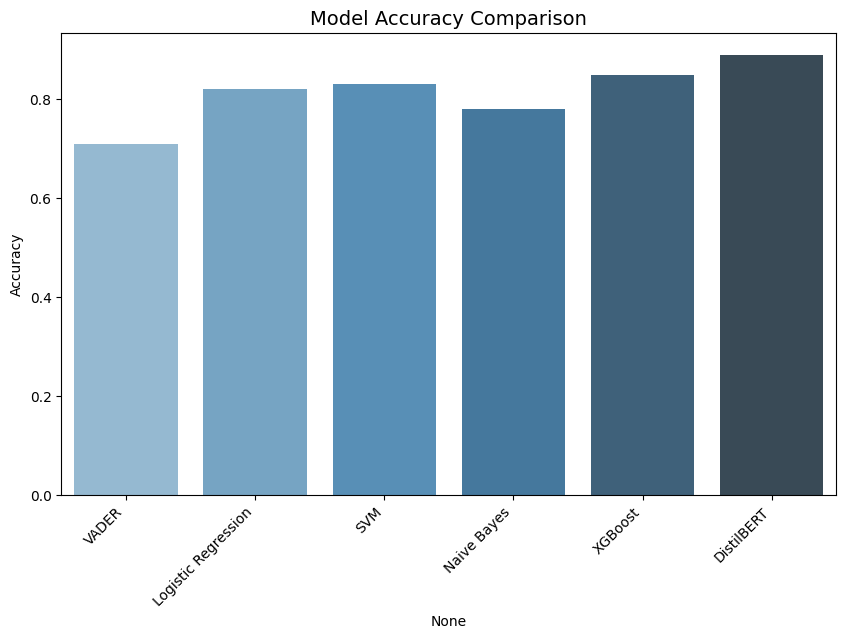

In [139]:
#plotting accuracy
plt.figure(figsize=(10,6))
sns.barplot(x=results_df.index, y="Accuracy", data=results_df.reset_index(), palette="Blues_d")
plt.title("Model Accuracy Comparison", fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.ylabel("Accuracy")
plt.show()

DistilBERT achieves the highest accuracy at approximately 89%, followed by XGBoost (85%) and Logistic Regression (82%). VADER shows the lowest performance at around 71%.

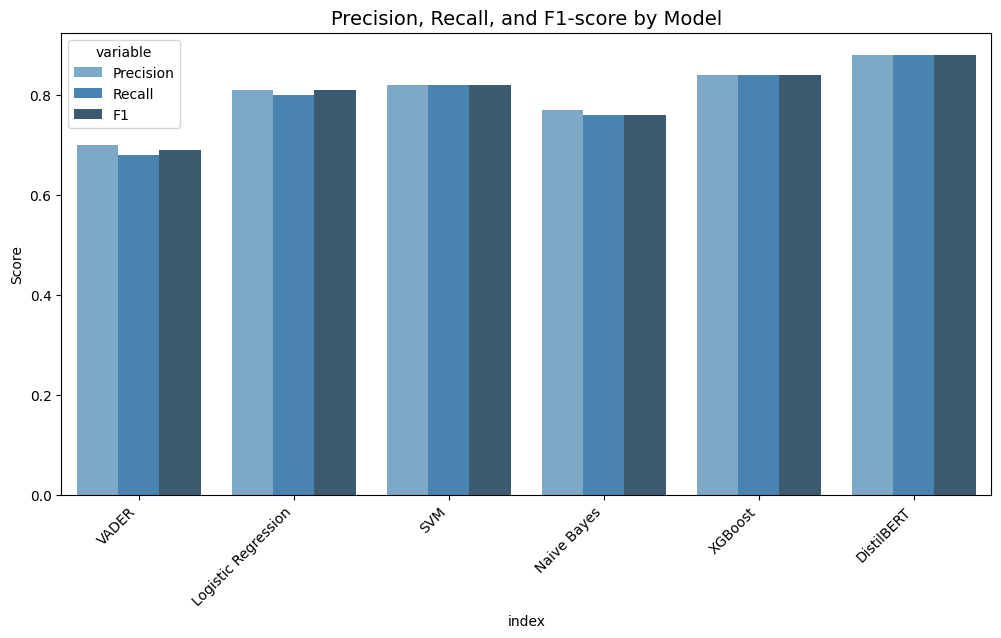

In [140]:
#plotting precision, recall and F-1 score
df_melted = results_df[["Precision", "Recall", "F1"]].reset_index().melt(id_vars="index")
plt.figure(figsize=(12,6))
sns.barplot(x="index", y="value", hue="variable", data=df_melted, palette="Blues_d")
plt.title("Precision, Recall, and F1-score by Model", fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.ylabel("Score")
plt.show()

To summarise, most models achieve balanced performance across metrics, with DistilBERT and XGBoost showing consistently high scores (0.85-0.9) across all three measures. VADER shows notable weakness in recall and F1-score despite reasonable precision.

##### Hybrid Model Approach

In [141]:
# before tuning
before_metrics = {
    "negative": {"precision": 0.60, "recall": 0.77, "f1": 0.67},
    "neutral":  {"precision": 0.47, "recall": 0.11, "f1": 0.18},
    "positive": {"precision": 0.63, "recall": 0.70, "f1": 0.66},
    "overall":  {"accuracy": 0.60, "AUC-ROC": 0.747, "AUC-PR": 0.585}
}

# after tuning
after_metrics = {
    "negative": {"precision": 0.61, "recall": 0.77, "f1": 0.68},
    "neutral":  {"precision": 0.37, "recall": 0.02, "f1": 0.05},
    "positive": {"precision": 0.62, "recall": 0.74, "f1": 0.67},
    "overall":  {"accuracy": 0.61, "AUC-ROC": 0.737, "AUC-PR": 0.567}
}

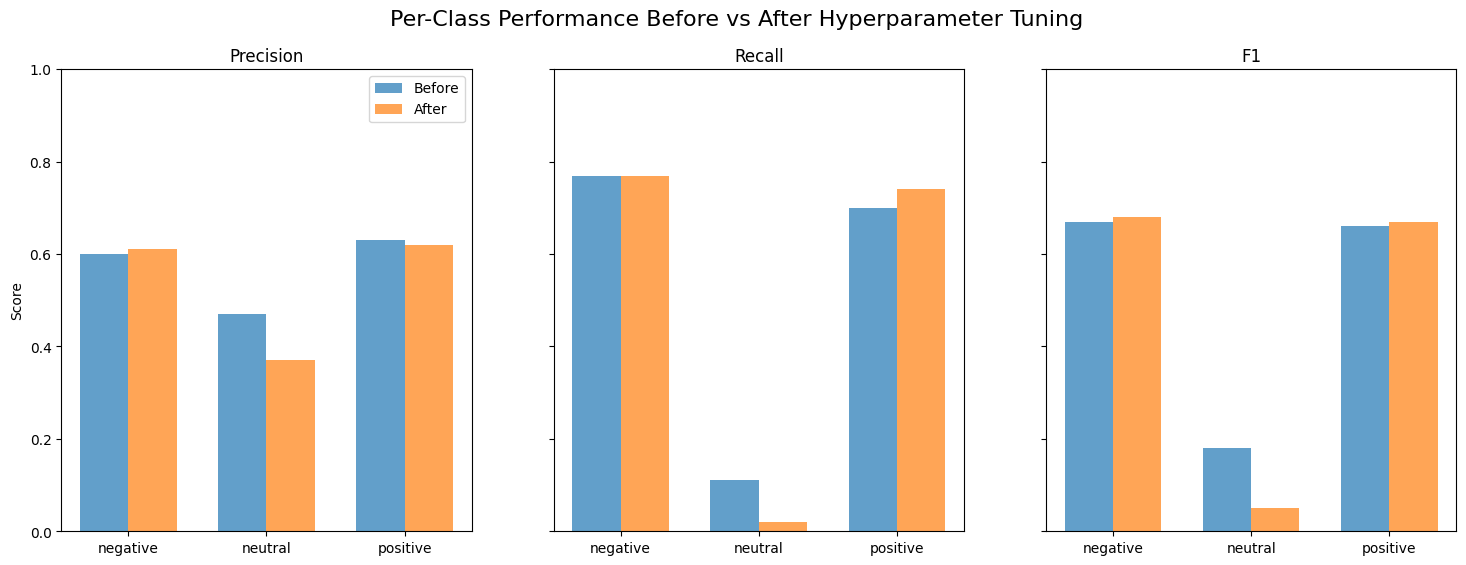

In [142]:
# per-class precision, recall, F1
classes = ["negative", "neutral", "positive"]
metrics = ["precision", "recall", "f1"]

x = np.arange(len(classes))  # class positions
width = 0.35  # bar width

fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

for i, metric in enumerate(metrics):
    before_vals = [before_metrics[c][metric] for c in classes]
    after_vals = [after_metrics[c][metric] for c in classes]

    axs[i].bar(x - width/2, before_vals, width, label="Before", alpha=0.7)
    axs[i].bar(x + width/2, after_vals, width, label="After", alpha=0.7)
    
    axs[i].set_xticks(x)
    axs[i].set_xticklabels(classes)
    axs[i].set_title(metric.capitalize())
    axs[i].set_ylim(0, 1)

axs[0].set_ylabel("Score")
axs[0].legend()
fig.suptitle("Per-Class Performance Before vs After Hyperparameter Tuning", fontsize=16)
plt.show()

Hyperparameter tuning shows mixed results, with improvements in positive class precision but deterioration in neutral class performance. The improvements are marginal (typically 1-3 percentage points). The decline in performance maybe due to the systemic lagging that occurs when using a large dataset and a pretrained model.

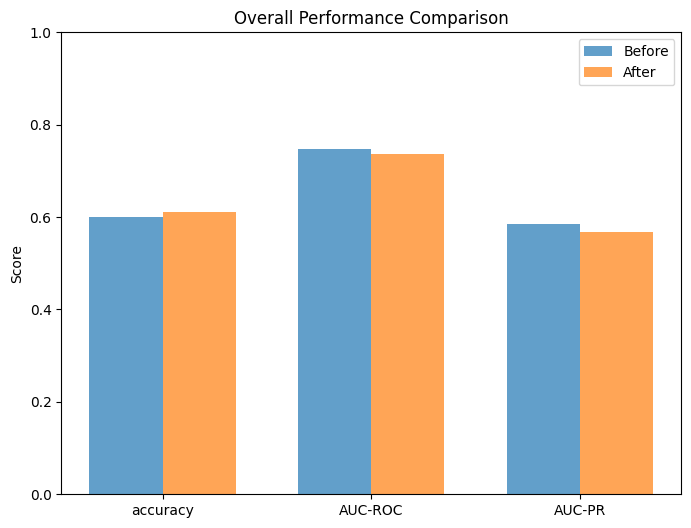

In [143]:
# overall metrics
overall_metrics = ["accuracy", "AUC-ROC", "AUC-PR"]

before_vals = [before_metrics["overall"][m] for m in overall_metrics]
after_vals = [after_metrics["overall"][m] for m in overall_metrics]

x = np.arange(len(overall_metrics))

plt.figure(figsize=(8,6))
plt.bar(x - width/2, before_vals, width, label="Before", alpha=0.7)
plt.bar(x + width/2, after_vals, width, label="After", alpha=0.7)

plt.xticks(x, overall_metrics)
plt.ylabel("Score")
plt.ylim(0,1)
plt.title("Overall Performance Comparison")
plt.legend()
plt.show()

Overall metrics show minimal improvement from hyperparameter tuning, with accuracy remaining virtually unchanged and AUC-ROC showing slight improvements. AUC-PR shows a marginal decline.

## Future Scope

Although the proposed project demonstrates success, further enhancements are necessary to transform it into a fully functional real-time sentiment analysis application. The following points outline potential directions for future work:

- Multimodal Analysis:
Beyond textual reviews, multimodal sentiment analysis incorporates both textual data and product images uploaded by customers. This fusion provides a richer representation of user sentiment, as visual cues such as product defects, quality indicators, or authenticity signals can complement textual opinions.

- Temporal Pattern Modeling:
Temporal dynamics are critical in understanding sentiment evolution over time. Techniques such as recurrent neural networks, temporal graph models, or time-series forecasting can reveal trends such as seasonal sentiment shifts, sentiment decay, or sudden anomalies following product launches or controversies.

- Adversarial Robustness Testing:
Sentiment analysis systems must be resilient to adversarial manipulation, such as artificially generated reviews, biased language injection, or multilingual spam. Robustness testing ensures that models maintain accuracy and fairness under adversarial conditions, which is crucial in e-commerce platforms vulnerable to review fraud.

- API-First Design & Web Application:
Designing sentiment analysis pipelines with an API-first approach promotes interoperability with recommendation engines, business intelligence dashboards, and third-party applications. This modular design also enhances reusability and integration within broader e-commerce ecosystems. The web application approach makes it a valuable asset to e-commerce ecosystems.

## Conclusion

This study has made a substantive contribution by addressing several critical gaps in existing multilingual sentiment analysis and bias detection research. First, it tackled the persistent challenge of neutral sentiment classification, integrating structured linguistic features with deep contextual embeddings to improve the detection of subtle, non-polarised expressions often overlooked in earlier models. Second, it responded to the problem of cultural context loss in translation-based or transfer learning approaches by employing multilingual embeddings that preserved linguistic nuances and semantic authenticity across six diverse languages. Third, it advanced beyond predominantly monolingual frameworks for bias detection by developing a culturally sensitive mechanism capable of identifying manipulation patterns that vary across linguistic and cultural boundaries. By addressing these gaps, the research not only strengthens the methodological foundations of cross-lingual sentiment analysis but also provides a practical framework for enhancing trust and reliability in global e-commerce platforms.